# Unraveling Gravitational Ripples: Neural Network Classification
### GASF vs FFT with New Data
### **GWGASF Members:** $Daniel\;Fredin^{1}$, $Cole\;Welch^{1}$, $Arif\;Chu^{1}$, $Chia-Jui\;Chou^{2}$, $Andy\;Chen^{2}$, & $Shih-Chieh\;Hsu^{1}$
#### $^{1}University\;of\;Washington,\;Seattle,\;USA$; $^{2}National\;Yang\;Ming\;Chiao\;Tung\;University,\;Hsinchu\;City,\;TW$

--------------------

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import h5py 
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.preprocessing import StandardScaler

from pyts.image import GramianAngularField

from scipy import signal
from gwpy.timeseries import TimeSeries
from gwpy.signal import filter_design

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from timeit import default_timer as timer
from tqdm import tqdm, tnrange, tqdm_notebook, trange
# from tqdm.notebook import trange

# Initializes numpy and pytorch random seeds for reproducibility 
seed = 55
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [2]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA GeForce GTX 1650
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


# Preparing the data

In [3]:
### -------------Load dataset------------- ###

# Define the file name
filename = 'classify_data.h5'

# Open the file
with h5py.File(filename, 'r') as file:
    # Load the datasets
    bbh_train = np.array(file['Training']['bbh'])
    bbh_val = np.array(file['Validation']['bbh'])
    glitch_train = np.array(file['Training']['glitch'])
    glitch_val = np.array(file['Validation']['glitch'])


### -------------Label our data as background or signal------------- ###

# Allows us to easily apply labels to our data to denote it as signal or background for classification.
anomaly_class = {
    'Glitch': 0,
    'Signal': 1
}

# ID our data as background or signal.
glitch_train_ids = np.full(glitch_train.shape[0], anomaly_class['Glitch'], dtype=int)
glitch_val_ids = np.full(glitch_val.shape[0], anomaly_class['Glitch'], dtype=int)

bbh_train_ids = np.full(bbh_train.shape[0], anomaly_class['Signal'], dtype=int)
bbh_val_ids = np.full(bbh_val.shape[0], anomaly_class['Signal'], dtype=int)



### -------------Merge dataset------------- ###

# Stick our background and signal data together for training and testing.
x_train = np.concatenate((glitch_train, bbh_train), axis=0).transpose((0,2,1))
y_train = np.concatenate((glitch_train_ids, bbh_train_ids), axis=0)

x_val_data = np.concatenate((glitch_val, bbh_val), axis=0).transpose((0,2,1))
y_val = np.concatenate((glitch_val_ids, bbh_val_ids), axis=0)



### -------------Shuffle dataset------------- ###

# Shuffle the training data using a randomly chosen permutation. This ensures we don't encounter artifacts from background 
# and signal data being clumped together.
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

#### Whitening and filtering

In [4]:
### -------------Split detector dataset------------- ###

# Each 2D dataset of gravitational wave data comes from one of two detectors: 1  and 2 
# Split the data from these two detectors since we can only pass 2D images into our CNN to train.
x_train_dec1_raw = x_train[:,:,0]
x_train_dec2_raw = x_train[:,:,1]

x_val_dec1_raw = x_val_data[:,:,0]
x_val_dec2_raw = x_val_data[:,:,1]




# Function to process a single item
def process_data(raw_data):


    # Bandpass filter for 50hz and 250hz
    bp = filter_design.bandpass(50, 250, 4096)

    ## First three harmonics of the 60 Hz AC mains power:
    notches = [filter_design.notch(line, 4096) for line in (60, 120, 180)]
    zpk = filter_design.concatenate_zpks(bp, *notches)



    hdata = TimeSeries(raw_data)
    hdata = hdata.whiten() 
    hdata = hdata.crop(*hdata.span.contract(1)) # The whitened timeseries data

    hfilt = hdata.filter(zpk, filtfilt=True)
    hfilt = hfilt.crop(*hfilt.span.contract(1)) # The filtered and whitened timeseries data

    return hdata, hfilt



### -------------Process training data------------- ###

x_train_dec1_data_arr = []
x_train_dec1_filt_arr = []

x_train_dec2_data_arr = []
x_train_dec2_filt_arr = []



x_val_dec1_data_arr = []
x_val_dec1_filt_arr = []

x_val_dec2_data_arr = []
x_val_dec2_filt_arr = []


for raw_data in tqdm(x_train_dec1_raw):
    hdata, hfilt = process_data(raw_data)
    x_train_dec1_data_arr.append(hdata)
    x_train_dec1_filt_arr.append(hfilt)

x_train_dec1_data_arr = np.asarray(x_train_dec1_data_arr)
x_train_dec1_filt_arr = np.asarray(x_train_dec1_filt_arr)


for raw_data in tqdm(x_train_dec2_raw):
    hdata, hfilt = process_data(raw_data)
    x_train_dec2_data_arr.append(hdata)
    x_train_dec2_filt_arr.append(hfilt)

x_train_dec2_data_arr = np.asarray(x_train_dec2_data_arr)
x_train_dec2_filt_arr = np.asarray(x_train_dec2_filt_arr)


for raw_data in tqdm(x_val_dec1_raw):
    hdata, hfilt = process_data(raw_data)
    x_val_dec1_data_arr.append(hdata)
    x_val_dec1_filt_arr.append(hfilt)

x_val_dec1_data_arr = np.asarray(x_val_dec1_data_arr)
x_val_dec1_filt_arr = np.asarray(x_val_dec1_filt_arr)


for raw_data in tqdm(x_val_dec2_raw):
    hdata, hfilt = process_data(raw_data)
    x_val_dec2_data_arr.append(hdata)
    x_val_dec2_filt_arr.append(hfilt)

x_val_dec2_data_arr = np.asarray(x_val_dec2_data_arr)
x_val_dec2_filt_arr = np.asarray(x_val_dec2_filt_arr)

  0%|          | 0/25598 [00:00<?, ?it/s]

100%|██████████| 598/598 [00:18<00:00, 32.28it/s]


In [5]:
### Write filtered and whitened data to file
filename = 'classify_data_filtered.h5'
hf = h5py.File(filename, 'w')

g1 = hf.create_group('Training/Det1')
g1.create_dataset('whitened',data=x_train_dec1_data_arr, compression="gzip", compression_opts = 5)
g1.create_dataset('Fwhitened',data=x_train_dec1_filt_arr, compression="gzip", compression_opts = 5)


g2 = hf.create_group('Training/Det2')
g2.create_dataset('whitened',data=x_train_dec2_data_arr, compression="gzip", compression_opts = 5)
g2.create_dataset('Fwhitened',data=x_train_dec2_filt_arr, compression="gzip", compression_opts = 5)

g3 = hf.create_group('Validation/Det1')
g3.create_dataset('whitened',data=x_val_dec1_data_arr, compression="gzip", compression_opts = 5)
g3.create_dataset('Fwhitened',data=x_val_dec1_filt_arr, compression="gzip", compression_opts = 5)


g4 = hf.create_group('Validation/Det2')
g4.create_dataset('whitened',data=x_val_dec2_data_arr, compression="gzip", compression_opts = 5)
g4.create_dataset('Fwhitened',data=x_val_dec2_filt_arr, compression="gzip", compression_opts = 5)

hf.close()

---

## NOTE: RESTART GASF HERE WITHOUT HAVING TO WHITEN AND FILTER

In [18]:
#### START HERE IF YOU NEED TO RESTART WITHOUT HAVING TO WHITEN AND FILTER

y_train = np.concatenate((glitch_train_ids, bbh_train_ids), axis=0)
y_train = y_train[idx]

### Read filtered data from file
filename = 'classify_data_filtered.h5'

# Open the file
with h5py.File(filename, 'r') as file:
    # Load the datasets

    x_train_dec1_data_arr = np.array(file['Training/Det1']['whitened'])
    x_train_dec2_data_arr = np.array(file['Training/Det2']['whitened'])
    x_train_dec1_filt_arr = np.array(file['Training/Det1']['Fwhitened'])
    x_train_dec2_filt_arr = np.array(file['Training/Det2']['Fwhitened'])


    x_val_dec1_data_arr = np.array(file['Validation/Det1']['whitened'])
    x_val_dec2_data_arr = np.array(file['Validation/Det2']['whitened'])
    x_val_dec1_filt_arr = np.array(file['Validation/Det1']['Fwhitened'])
    x_val_dec2_filt_arr = np.array(file['Validation/Det2']['Fwhitened'])
    
    file.close()


# # The filtered data
# x_train_dec1 = x_train_dec1_filt_arr
# x_train_dec2 = x_train_dec2_filt_arr
# x_val_dec1 = x_val_dec1_filt_arr
# x_val_dec2 = x_val_dec2_filt_arr

# The whitened data
x_train_dec1 = x_train_dec1_data_arr
x_train_dec2 = x_train_dec2_data_arr
x_val_dec1 = x_val_dec1_data_arr
x_val_dec2 = x_val_dec2_data_arr

-----

# Converting to ...

### GASF

In [8]:
### -------------Convert dataset to GASF------------- ###
convrt_index = 0
# Utilize Gramian Angular Fields to transform our image from time series to images 
# so that we can apply a CNN for classification. See for an explanation: 
# Imaging Time-Series to Improve Classification and Imputation. 
# Zhiguang Wang and Tim Oates. 
# https://arxiv.org/pdf/1506.00327

## NOTE: NEED TO HAVE USER INPUT FOR IMAGE SIZE??

# gasf = GramianAngularField(image_size=129, sample_range = (-1,1), method="summation")
gasf = GramianAngularField(image_size=64, sample_range = (-1,1), method="summation")
# Convert training data to image format
img_x_train_dec1 = gasf.transform(x_train_dec1)
img_x_train_dec2 = gasf.transform(x_train_dec2)

# Convert testing data to image format
img_x_val_dec1 = gasf.transform(x_val_dec1)
img_x_val_dec2 = gasf.transform(x_val_dec2)


### FFT

#### Stride search

In [ ]:
# data = (x_train_dec1[50,:])
# series = (TimeSeries(data, sample_rate = 4096, t0=0))     #np.array --> constantQ.timeseries   

# ts = series
# # ts_plot = ts.plot()
# # plt.xlim(0,1)
# # plt.show()

# # # Spectrogram
# stride = 0.0309
# fftlength = stride
# overlap = fftlength/2
# ts_spectro = ts.spectrogram2(
#     # stride=stride,
#     fftlength=fftlength,
#     overlap=overlap,
# ) ** (1/2.)


# # spectro_plot = ts_spectro.plot(norm='log')
# # ax = spectro_plot.gca()
# # ax.set_ylim(20, 500)
# # ax.set_xlim(0, 1)
# # ax.colorbar(label='strain ASD')
# # spectro_plot.show()
# print(ts_spectro.shape)

In [20]:
### -------------Convert to FFT Spectrograms------------- ###
## NOTE: TURN INTO A FUNCTION TO SIMPLIFY READABILITY
convrt_index = 1

data_list = []
series_list = []
fft_list = []

stride = 0.0309
fftlength = stride
overlap = fftlength/2


datas = [x_train_dec1, x_train_dec2, x_val_dec1, x_val_dec2]

for d in range(len(datas)):
    data_list = []
    series_list = []
    fft_list = []


    for i in range(len(datas[d])):
        data = (datas[d][i,:])
        data_list.append(data)
        # print(datas[d].shape)
        series = (TimeSeries(data, sample_rate = 4096, t0=0))     #np.array --> constantQ.timeseries   
        series_list.append(series)

        series_spectro = series.spectrogram2(
            fftlength=fftlength,
            overlap=overlap,
        ) ** (1/2.)
        fft_list.append(series_spectro)




    if d == 0:
        data_arr_x_train_dec1 = np.stack(data_list, axis = 0)
        series_arr_x_train_dec1 = np.asarray(series_list)
        # fft_arr_x_train_dec1 = np.stack(fft_list, axis = 0)
        fft_arr_x_train_dec1 = np.asarray(fft_list)


    elif d == 1:
        data_arr_x_train_dec2 = np.stack(data_list, axis = 0)
        series_arr_x_train_dec2 = np.asarray(series_list)
        fft_arr_x_train_dec2 = np.asarray(fft_list)

    elif d == 2:
        data_arr_x_test_dec1 = np.stack(data_list, axis = 0)
        series_arr_x_test_dec1 = np.asarray(series_list)
        fft_arr_x_test_dec1 = np.asarray(fft_list)

    else:
        data_arr_x_test_dec2 = np.stack(data_list, axis = 0)
        series_arr_x_test_dec2 = np.asarray(series_list)
        fft_arr_x_test_dec2 = np.asarray(fft_list)




img_x_train_dec1 = fft_arr_x_train_dec1
img_x_train_dec2 = fft_arr_x_train_dec2
img_x_val_dec1 = fft_arr_x_test_dec1
img_x_val_dec2 = fft_arr_x_test_dec2


### Q Transform

#### tres and fres search

In [ ]:
# data = (x_train_dec1[14120,:])
# series = (TimeSeries(data, sample_rate = 4096, t0=0))     #np.array --> constantQ.timeseries   

# ts = series
# ts_plot = ts.plot()
# plt.xlim(0,1)
# plt.show()

# # # Q-Transformation
# ts_qspectro = ts.q_transform(
#     qrange=(3.3166, 108),
#     frange=(20, 1054),
#     whiten=False,
#     tres = 0.0158,
#     fres = 16.25)
# print(ts_qspectro.shape)

# q_plot = ts_qspectro.plot()
# ax = q_plot.gca()
# ax.set_xscale('seconds')
# ax.set_yscale('log')
# # ax.set_xlim(3.5, 4.5)
# ax.set_ylim(20, 500)
# ax.set_ylabel('Frequency [Hz]')
# ax.grid(True, axis='y', which='both')
# ax.colorbar(cmap='viridis', label='Normalized energy')
# q_plot.show()


In [7]:
### -------------Convert to Q Spectrograms------------- ###
## NOTE: TURN INTO A FUNCTION TO SIMPLIFY READABILITY
convrt_index = 2

data_list = []
series_list = []
Q_list = []


datas = [x_train_dec1, x_train_dec2, x_val_dec1, x_val_dec2]

for d in range(len(datas)):
    data_list = []
    series_list = []
    Q_list = []


    for i in range(len(datas[d])):
        data = (datas[d][i,:])
        data_list.append(data)
        # print(datas[d].shape)
        series = (TimeSeries(data, sample_rate = 4096, t0=0))     #np.array --> constantQ.timeseries   
        series_list.append(series)

        series_spectro = series.q_transform(
        qrange=(3.3166, 108),
        frange=(20, 1054),
        whiten=False,
        tres = 0.0158,
        fres = 16.25)
        Q_list.append(series_spectro)




    if d == 0:
        data_arr_x_train_dec1 = np.stack(data_list, axis = 0)
        series_arr_x_train_dec1 = np.asarray(series_list)
        # Q_arr_x_train_dec1 = np.stack(Q_list, axis = 0)
        Q_arr_x_train_dec1 = np.asarray(Q_list)


    elif d == 1:
        data_arr_x_train_dec2 = np.stack(data_list, axis = 0)
        series_arr_x_train_dec2 = np.asarray(series_list)
        Q_arr_x_train_dec2 = np.asarray(Q_list)

    elif d == 2:
        data_arr_x_test_dec1 = np.stack(data_list, axis = 0)
        series_arr_x_test_dec1 = np.asarray(series_list)
        Q_arr_x_test_dec1 = np.asarray(Q_list)

    else:
        data_arr_x_test_dec2 = np.stack(data_list, axis = 0)
        series_arr_x_test_dec2 = np.asarray(series_list)
        Q_arr_x_test_dec2 = np.asarray(Q_list)




img_x_train_dec1 = Q_arr_x_train_dec1
img_x_train_dec2 = Q_arr_x_train_dec2
img_x_val_dec1 = Q_arr_x_test_dec1
img_x_val_dec2 = Q_arr_x_test_dec2

X Training Shape:  (22854, 2, 64, 64)
Y Training Shape:  (22854,)
X Testing Shape:  (2744, 2, 64, 64)
Y Testing Shape:  (2744,)
X Validation Shape:  (598, 2, 64, 64)
Y Validation Shape:  (598,)


---

In [21]:
# Stack Detector 1 and Detector 2 image data together to unify our training and testing datasets before training.
x_train = np.stack((img_x_train_dec1, img_x_train_dec2), axis=1)
x_val = np.stack((img_x_val_dec1, img_x_val_dec2), axis=1)

### -------------Split into training and validation datasets------------- ###

## NOTE: MAYBE USER INPUT FOR SPLIT %???

# Take the first 17.65% of our training features and targets as validation set
x_test= x_train[:round((len(x_train)*0.1072))]
y_test = y_train[:round((len(y_train)*0.1072))]

# Take the remaining 82.35% of training features and targets as training set
x_train = x_train[round((len(x_train)*0.1072)):]
y_train = y_train[round((len(y_train)*0.1072)):]

# Check the shapes of the training/validation datasets. Turns out we get about a 80%, 13%, 2% split.
print("X Training Shape: ", x_train.shape)
print("Y Training Shape: ", y_train.shape)
print("X Testing Shape: ", x_test.shape)
print("Y Testing Shape: ", y_test.shape)
print("X Validation Shape: ", x_val.shape)
print("Y Validation Shape: ", y_val.shape)

X Training Shape:  (22854, 2, 64, 64)
Y Training Shape:  (22854,)
X Testing Shape:  (2744, 2, 64, 64)
Y Testing Shape:  (2744,)
X Validation Shape:  (598, 2, 64, 64)
Y Validation Shape:  (598,)


## CNN Model

In [22]:
### -------------Model Definition------------- ###

class CNNModel(torch.nn.Module):
    
    def __init__(self):
        
        super(CNNModel, self).__init__()

        # First convolution layer (2 channel -> 16 channels, preserve original dimension by adding padding = 2) 
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=2, out_channels=16, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=4, stride=2, padding=1)
            )
        
        # Second convolution layer (16 channel -> 32 channels, preserve dimension by adding padding = 2)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
            )

        # Fully connected layer that takes the flattened output of layer 2 (32, 7 ,7) -> (1568) and output 2 classes
        self.fc1 = torch.nn.Linear(in_features=32*8*8, out_features=128)
        self.fc2 = torch.nn.Linear(in_features=128, out_features=64)
        self.fc3 = torch.nn.Linear(in_features=64, out_features=2)
    
    def forward(self, x):

        # input image -> conv -> batchnorm -> relu -> maxpool
        out = self.layer1(x)
        # 1st maxpool output -> conv -> batchnorm -> relu -> maxpool
        out = self.layer2(out)
        # flatten the second maxpool output to be used as input into FCN layer
        out = out.view(out.size(0), -1)

        # Pass flattened output into FCN layers
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out


# ### -------------Model Definition------------- ###

# class CNNModel(torch.nn.Module):
    
#     def __init__(self):
        
#         super(CNNModel, self).__init__()

#                 # First convolution layer (2 channel -> 16 channels, preserve original dimension by adding padding = 2) 
#         self.layer1 = torch.nn.Sequential(
#             torch.nn.Conv2d(in_channels=2, out_channels=16, kernel_size=5, stride=2, padding=2),
#             torch.nn.BatchNorm2d(16),
#             torch.nn.ReLU(),
#             torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
#             )
        
#         # Second convolution layer (16 channel -> 32 channels, preserve dimension by adding padding = 2)
#         self.layer2 = torch.nn.Sequential(
#             torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=2, padding=1),
#             torch.nn.BatchNorm2d(32),
#             torch.nn.ReLU(),
#             torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
#             )

#         # Fully connected layer that takes the flattened output of layer 2 (32, 7 ,7) -> (1568) and output 2 classes
#         self.fc1 = torch.nn.Linear(in_features=32*8*8, out_features=128)
#         self.fc2 = torch.nn.Linear(in_features=128, out_features=64)
#         self.fc3 = torch.nn.Linear(in_features=64, out_features=2)
    
#     def forward(self, x):

#         # input image -> conv -> batchnorm -> relu -> maxpool
#         out = self.layer1(x)
#         # 1st maxpool output -> conv -> batchnorm -> relu -> maxpool
#         out = self.layer2(out)
#         # flatten the second maxpool output to be used as input into FCN layer
#         out = out.view(out.size(0), -1)

#         # Pass flattened output into FCN layers
#         out = self.fc1(out)
#         out = self.fc2(out)
#         out = self.fc3(out)
        
#         return out

## Hyperparameters

In [23]:
### -------------Hyperparameters------------- ###

# Initialize the CNN model
model = CNNModel()
learning_rate = 0.00005      #0.00005
epochs = 40                 # 75
batchsize = 768
L2_reg = 0.00005

# Define loss function and optimizer
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=L2_reg)

if torch.cuda.is_available():                                  # Checks if the GPU is available for processing
    model.cuda()                                               # Sends the model to the GPU for processing
model        

### -------------Creating Training Model inputs------------- ###

if torch.cuda.is_available():                   # If using CUDA version of PyTorch, dataset will be processed on GPU

    # Convert train/validation/test sets into torch tensors from numpy
    train_inputs = torch.from_numpy(x_train).float().cuda()
    train_targets = torch.from_numpy(y_train).long().cuda()

    validation_inputs = torch.from_numpy(x_val).float().cuda()
    validation_targets = torch.from_numpy(y_val).long().cuda()

    testing_inputs = torch.from_numpy(x_test).float().cuda()
    testing_targets = torch.from_numpy(y_test).long().cuda()

    # Split the training inputs/targets into mini-batches
    train_batches_features = torch.split(train_inputs, batchsize)
    train_batches_targets = torch.split(train_targets, batchsize)

else:                                           # If not using CUDA version of PyTorch, dataset will be processed on CPU

    # Convert train/validation/test sets into torch tensors from numpy
    train_inputs = torch.from_numpy(x_train).float()
    train_targets = torch.from_numpy(y_train).long()

    validation_inputs = torch.from_numpy(x_val).float()
    validation_targets = torch.from_numpy(y_val).long()

    testing_inputs = torch.from_numpy(x_test).float()
    testing_targets = torch.from_numpy(y_test).long()

    # Split the training inputs/targets into mini-batches
    train_batches_features = torch.split(train_inputs, batchsize)
    train_batches_targets = torch.split(train_targets, batchsize)

# length of train_batches_features = total number of mini-batches in the training set
batch_split_num = len(train_batches_features)


### -------------Identify tracked values------------- ###

train_loss_list = []
validation_accuracy_list = np.zeros((epochs,))


## Training loop

In [24]:
### -------------Training Loop------------- ###
## NOTE: CHANGE DESC TO INCLUDE CHANGING EPOCHS

for epoch in trange(epochs, desc='Training Model on 40 Epochs'):
    start_time = timer() # start timer
    # Each mini-batch number i, grab i-th training feature and target mini-batch and perform fwd/bwd pass on the network
    
    # for i in trange(batch_split_num, desc=f'Epoch {epoch}'):
    for i in range(batch_split_num):
    
        optimizer.zero_grad()    
        train_batch_outputs = model(train_batches_features[i])  
        loss = loss_func(train_batch_outputs, train_batches_targets[i])
        train_loss_list.append(loss.item())       
        loss.backward()
        optimizer.step()

    end_time = timer() # End timer

### -------------Compute Validation Accuracy------------- ###

    with torch.no_grad():

        validation_outputs = model(validation_inputs)
        val_correct = (torch.argmax(validation_outputs, dim=1) == validation_targets).type(torch.FloatTensor) 
        validation_accuracy_list[epoch] = val_correct.mean()

        print("Epoch: "+ str(epoch),
              "Epoch time: " + str(np.round(end_time - start_time, 2)) + "s",
              "Validation Accuracy: " + str(np.round(val_correct.mean().numpy() * 100, 2)) + '%',
              "Training loss: " + str(np.round(loss.item(), 2)), flush=True)

Training Model on 40 Epochs:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Epoch time: 0.92s Validation Accuracy: 54.35% Training loss: 0.68


Training Model on 40 Epochs:   2%|▎         | 1/40 [00:00<00:36,  1.06it/s]

Epoch: 1 Epoch time: 0.89s Validation Accuracy: 54.85% Training loss: 0.67


Training Model on 40 Epochs:   5%|▌         | 2/40 [00:01<00:35,  1.08it/s]

Epoch: 2 Epoch time: 0.82s Validation Accuracy: 49.83% Training loss: 0.65


Training Model on 40 Epochs:   8%|▊         | 3/40 [00:02<00:32,  1.12it/s]

Epoch: 3 Epoch time: 0.81s Validation Accuracy: 51.67% Training loss: 0.62


Training Model on 40 Epochs:  10%|█         | 4/40 [00:03<00:31,  1.15it/s]

Epoch: 4 Epoch time: 0.81s Validation Accuracy: 55.69% Training loss: 0.56


Training Model on 40 Epochs:  12%|█▎        | 5/40 [00:04<00:30,  1.16it/s]

Epoch: 5 Epoch time: 0.83s Validation Accuracy: 62.21% Training loss: 0.49


Training Model on 40 Epochs:  15%|█▌        | 6/40 [00:05<00:29,  1.16it/s]

Epoch: 6 Epoch time: 0.84s Validation Accuracy: 71.91% Training loss: 0.42


Training Model on 40 Epochs:  18%|█▊        | 7/40 [00:06<00:28,  1.16it/s]

Epoch: 7 Epoch time: 0.85s Validation Accuracy: 76.76% Training loss: 0.35


Training Model on 40 Epochs:  20%|██        | 8/40 [00:06<00:27,  1.15it/s]

Epoch: 8 Epoch time: 0.84s Validation Accuracy: 78.09% Training loss: 0.3


Training Model on 40 Epochs:  22%|██▎       | 9/40 [00:07<00:26,  1.15it/s]

Epoch: 9 Epoch time: 0.83s Validation Accuracy: 79.26% Training loss: 0.26


Training Model on 40 Epochs:  25%|██▌       | 10/40 [00:08<00:25,  1.16it/s]

Epoch: 10 Epoch time: 0.85s Validation Accuracy: 81.61% Training loss: 0.24


Training Model on 40 Epochs:  28%|██▊       | 11/40 [00:09<00:25,  1.15it/s]

Epoch: 11 Epoch time: 0.86s Validation Accuracy: 82.27% Training loss: 0.21


Training Model on 40 Epochs:  30%|███       | 12/40 [00:10<00:24,  1.15it/s]

Epoch: 12 Epoch time: 0.78s Validation Accuracy: 83.95% Training loss: 0.2


Training Model on 40 Epochs:  32%|███▎      | 13/40 [00:11<00:23,  1.17it/s]

Epoch: 13 Epoch time: 0.78s Validation Accuracy: 84.78% Training loss: 0.19


Training Model on 40 Epochs:  35%|███▌      | 14/40 [00:12<00:21,  1.19it/s]

Epoch: 14 Epoch time: 0.78s Validation Accuracy: 84.78% Training loss: 0.18


Training Model on 40 Epochs:  38%|███▊      | 15/40 [00:12<00:20,  1.20it/s]

Epoch: 15 Epoch time: 0.78s Validation Accuracy: 88.63% Training loss: 0.18


Training Model on 40 Epochs:  40%|████      | 16/40 [00:13<00:19,  1.21it/s]

Epoch: 16 Epoch time: 0.79s Validation Accuracy: 87.63% Training loss: 0.17


Training Model on 40 Epochs:  42%|████▎     | 17/40 [00:14<00:18,  1.22it/s]

Epoch: 17 Epoch time: 0.79s Validation Accuracy: 89.97% Training loss: 0.18


Training Model on 40 Epochs:  45%|████▌     | 18/40 [00:15<00:18,  1.22it/s]

Epoch: 18 Epoch time: 0.82s Validation Accuracy: 91.14% Training loss: 0.16


Training Model on 40 Epochs:  48%|████▊     | 19/40 [00:16<00:17,  1.21it/s]

Epoch: 19 Epoch time: 0.83s Validation Accuracy: 94.48% Training loss: 0.16


Training Model on 40 Epochs:  50%|█████     | 20/40 [00:17<00:16,  1.20it/s]

Epoch: 20 Epoch time: 0.79s Validation Accuracy: 93.81% Training loss: 0.15


Training Model on 40 Epochs:  52%|█████▎    | 21/40 [00:17<00:15,  1.20it/s]

Epoch: 21 Epoch time: 0.79s Validation Accuracy: 93.31% Training loss: 0.14


Training Model on 40 Epochs:  55%|█████▌    | 22/40 [00:18<00:14,  1.21it/s]

Epoch: 22 Epoch time: 0.82s Validation Accuracy: 93.81% Training loss: 0.14


Training Model on 40 Epochs:  57%|█████▊    | 23/40 [00:19<00:14,  1.20it/s]

Epoch: 23 Epoch time: 0.8s Validation Accuracy: 93.81% Training loss: 0.13


Training Model on 40 Epochs:  60%|██████    | 24/40 [00:20<00:13,  1.20it/s]

Epoch: 24 Epoch time: 0.79s Validation Accuracy: 93.98% Training loss: 0.13


Training Model on 40 Epochs:  62%|██████▎   | 25/40 [00:21<00:12,  1.21it/s]

Epoch: 25 Epoch time: 0.8s Validation Accuracy: 94.31% Training loss: 0.13


Training Model on 40 Epochs:  65%|██████▌   | 26/40 [00:22<00:11,  1.21it/s]

Epoch: 26 Epoch time: 0.84s Validation Accuracy: 94.65% Training loss: 0.13


Training Model on 40 Epochs:  68%|██████▊   | 27/40 [00:22<00:10,  1.19it/s]

Epoch: 27 Epoch time: 0.84s Validation Accuracy: 94.48% Training loss: 0.12


Training Model on 40 Epochs:  70%|███████   | 28/40 [00:23<00:10,  1.18it/s]

Epoch: 28 Epoch time: 0.8s Validation Accuracy: 94.48% Training loss: 0.12


Training Model on 40 Epochs:  72%|███████▎  | 29/40 [00:24<00:09,  1.19it/s]

Epoch: 29 Epoch time: 0.81s Validation Accuracy: 94.82% Training loss: 0.12


Training Model on 40 Epochs:  75%|███████▌  | 30/40 [00:25<00:08,  1.19it/s]

Epoch: 30 Epoch time: 0.8s Validation Accuracy: 94.82% Training loss: 0.11


Training Model on 40 Epochs:  78%|███████▊  | 31/40 [00:26<00:07,  1.20it/s]

Epoch: 31 Epoch time: 0.79s Validation Accuracy: 95.15% Training loss: 0.11


Training Model on 40 Epochs:  80%|████████  | 32/40 [00:27<00:06,  1.20it/s]

Epoch: 32 Epoch time: 0.79s Validation Accuracy: 95.15% Training loss: 0.11


Training Model on 40 Epochs:  82%|████████▎ | 33/40 [00:27<00:05,  1.21it/s]

Epoch: 33 Epoch time: 0.8s Validation Accuracy: 95.15% Training loss: 0.1


Training Model on 40 Epochs:  85%|████████▌ | 34/40 [00:28<00:04,  1.21it/s]

Epoch: 34 Epoch time: 0.79s Validation Accuracy: 95.15% Training loss: 0.11


Training Model on 40 Epochs:  88%|████████▊ | 35/40 [00:29<00:04,  1.21it/s]

Epoch: 35 Epoch time: 0.81s Validation Accuracy: 95.15% Training loss: 0.11


Training Model on 40 Epochs:  90%|█████████ | 36/40 [00:30<00:03,  1.21it/s]

Epoch: 36 Epoch time: 0.82s Validation Accuracy: 95.15% Training loss: 0.11


Training Model on 40 Epochs:  92%|█████████▎| 37/40 [00:31<00:02,  1.20it/s]

Epoch: 37 Epoch time: 0.82s Validation Accuracy: 95.48% Training loss: 0.11


Training Model on 40 Epochs:  95%|█████████▌| 38/40 [00:32<00:01,  1.20it/s]

Epoch: 38 Epoch time: 0.8s Validation Accuracy: 95.48% Training loss: 0.1


Training Model on 40 Epochs:  98%|█████████▊| 39/40 [00:32<00:00,  1.20it/s]

Epoch: 39 Epoch time: 0.8s Validation Accuracy: 95.48% Training loss: 0.1


Training Model on 40 Epochs: 100%|██████████| 40/40 [00:33<00:00,  1.19it/s]


## Visualize & Evaluate Model

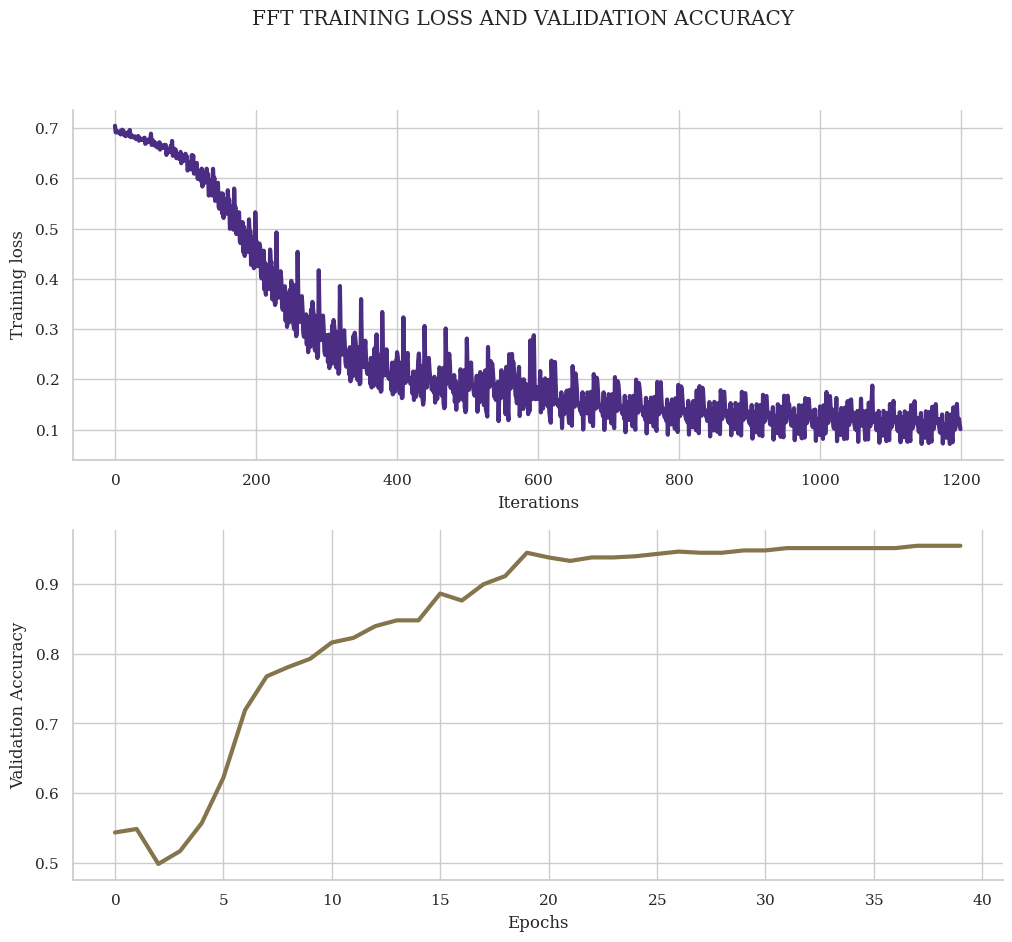

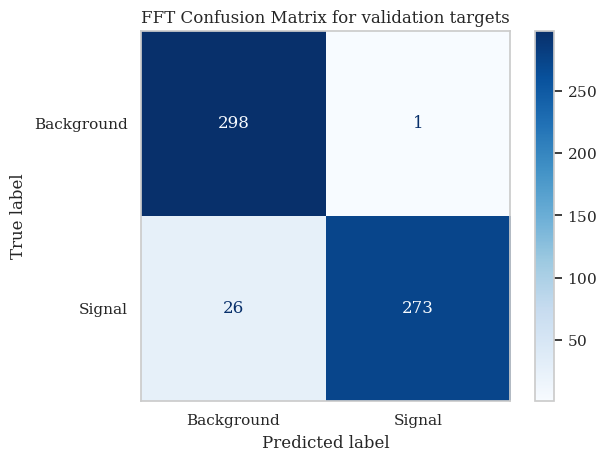

In [25]:
### Generalized 


# torch.cuda.empty_cache()

### -------------Computing the Training accuracy------------- ###

with torch.no_grad():

    target_pred_test = model(train_inputs)
    train_correct = (torch.argmax(target_pred_test, dim=1) == train_targets).type(torch.FloatTensor)
    train_testing_acc = (train_correct.mean().numpy()*100)

### -------------Computing the testing accuracy------------- ###

with torch.no_grad():

    target_pred_test = model(testing_inputs)
    test_correct = (torch.argmax(target_pred_test, dim=1) == testing_targets).type(torch.FloatTensor)
    test_testing_acc = (test_correct.mean().numpy()*100) 

### -------------Computing the validation accuracy------------- ###

with torch.no_grad():

    target_pred_test = model(validation_inputs)
    val_correct = (torch.argmax(target_pred_test, dim=1) == validation_targets).type(torch.FloatTensor)
    val_testing_acc = (val_correct.mean().numpy()*100)
    
### -------------Confusion Matrix------------- ###

actual = validation_targets.cpu().numpy()
predicted = (torch.argmax(model(validation_inputs), dim=1)).cpu().numpy()

cm = confusion_matrix(actual, predicted)

Accuracy = metrics.accuracy_score(actual, predicted)*100
Precision = metrics.precision_score(actual, predicted)*100
Sensitivity_recall = metrics.recall_score(actual, predicted)*100
Specificity = metrics.recall_score(actual, predicted, pos_label=0)*100
F1_score = metrics.f1_score(actual, predicted)*100

acc = {'Training Accuracy': [train_testing_acc],
           'Testing Accuracy': [test_testing_acc],
           'Validation Accuracy': [val_testing_acc]}

results = pd.DataFrame(acc)

val = {'Accuracy': [Accuracy],
       'Precision': [Precision],
       'Sensitivity_recall': [Sensitivity_recall],
       'Specificity': [Specificity],
       'F1_score': [F1_score]}

val_results = pd.DataFrame(val)

### -------------Plot the training loss and validation accuracy------------- ###

sns.set(style = 'whitegrid', font_scale = 1)
plt.figure(figsize = (12,10))
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.sans-serif"] = "Open Sans"

plt.subplot(2, 1, 1)
plt.plot(train_loss_list, linewidth = 3, color="#4b2e83")
plt.ylabel("Training loss")
plt.xlabel("Iterations")


plt.subplot(2, 1, 2)
plt.plot(validation_accuracy_list, linewidth = 3, color = "#85754d")
plt.ylabel("Validation Accuracy")
plt.xlabel("Epochs")







### NON General

## GASF 
if convrt_index == 0:


    # Plot train loss and val acc
    plt.suptitle("GASF TRAINING LOSS AND VALIDATION ACCURACY")
    sns.despine()
    plt.savefig("GASF_TrainLoss_ValAcc.png")


    # Plot Confusion matrix
    cm_display = metrics.ConfusionMatrixDisplay(cm, 
                                                display_labels = ('Background', 'Signal'))
    cm_display.plot(cmap=plt.cm.Blues, values_format = '')
    plt.title('GASF Confusion Matrix for validation targets')
    plt.grid(False)
    plt.savefig("GASF_ConfMatrix.png")
    plt.show()

    # Save results to csv
    results.style.set_caption("GASF Accuracy Results")
    results.to_csv('GASF Accuracy Results.csv', encoding='utf-8', index=False)

    val_results.style.set_caption("GASF Validation Results")
    val_results.to_csv('GASF Validation Results.csv', encoding='utf-8', index=False)



## FFT 
elif convrt_index == 1:


    # Plot train loss and val acc
    plt.suptitle("FFT TRAINING LOSS AND VALIDATION ACCURACY")
    sns.despine()
    plt.savefig("FFT_TrainLoss_ValAcc.png")


    # Plot Confusion matrix
    cm_display = metrics.ConfusionMatrixDisplay(cm, 
                                                display_labels = ('Background', 'Signal'))
    cm_display.plot(cmap=plt.cm.Blues, values_format = '')
    plt.title('FFT Confusion Matrix for validation targets')
    plt.grid(False)
    plt.savefig("FFT_ConfMatrix.png")
    plt.show()

    # Save results to csv
    results.style.set_caption("FFT Accuracy Results")
    results.to_csv('FFT Accuracy Results.csv', encoding='utf-8', index=False)

    val_results.style.set_caption("FFT Validation Results")
    val_results.to_csv('FFT Validation Results.csv', encoding='utf-8', index=False)







## Q 
elif convrt_index == 2:


    # Plot train loss and val acc
    plt.suptitle("Q TRAINING LOSS AND VALIDATION ACCURACY")
    sns.despine()
    plt.savefig("Q_TrainLoss_ValAcc.png")


    # Plot Confusion matrix
    cm_display = metrics.ConfusionMatrixDisplay(cm, 
                                                display_labels = ('Background', 'Signal'))
    cm_display.plot(cmap=plt.cm.Blues, values_format = '')
    plt.title('Q Confusion Matrix for validation targets')
    plt.grid(False)
    plt.savefig("Q_ConfMatrix.png")
    plt.show()

    # Save results to csv
    results.style.set_caption("Q Accuracy Results")
    results.to_csv('Q Accuracy Results.csv', encoding='utf-8', index=False)

    val_results.style.set_caption("Q Validation Results")
    val_results.to_csv('Q Validation Results.csv', encoding='utf-8', index=False)







-------

# FFT

## Preparing the data

In [3]:
# Might consider doing this to prevent crashing
torch.cuda.empty_cache() 

### -------------Load dataset------------- ###

# Define the file name
filename = 'classify_data.h5'

# Open the file
with h5py.File(filename, 'r') as file:
    # Load the datasets
    bbh_train = np.array(file['Training']['bbh'])
    bbh_val = np.array(file['Validation']['bbh'])
    glitch_train = np.array(file['Training']['glitch'])
    glitch_val = np.array(file['Validation']['glitch'])


### -------------Label our data as background or signal------------- ###

# Allows us to easily apply labels to our data to denote it as signal or background for classification.
anomaly_class = {
    'Glitch': 0,
    'Signal': 1
}

# ID our data as background or signal.
glitch_train_ids = np.full(glitch_train.shape[0], anomaly_class['Glitch'], dtype=int)
glitch_val_ids = np.full(glitch_val.shape[0], anomaly_class['Glitch'], dtype=int)

bbh_train_ids = np.full(bbh_train.shape[0], anomaly_class['Signal'], dtype=int)
bbh_val_ids = np.full(bbh_val.shape[0], anomaly_class['Signal'], dtype=int)



### -------------Merge dataset------------- ###

# Stick our background and signal data together for training and testing.
x_train = np.concatenate((glitch_train, bbh_train), axis=0).transpose((0,2,1))
y_train = np.concatenate((glitch_train_ids, bbh_train_ids), axis=0)

x_val_data = np.concatenate((glitch_val, bbh_val), axis=0).transpose((0,2,1))
y_val = np.concatenate((glitch_val_ids, bbh_val_ids), axis=0)



### -------------Shuffle dataset------------- ###

# Shuffle the training data using a randomly chosen permutation. This ensures we don't encounter artifacts from background 
# and signal data being clumped together.
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

#### Whitening and filtering

In [4]:
### -------------Split detector dataset------------- ###

# Each 2D dataset of gravitational wave data comes from one of two detectors: 1  and 2 
# Split the data from these two detectors since we can only pass 2D images into our CNN to train.
x_train_dec1_raw = x_train[:,:,0]
x_train_dec2_raw = x_train[:,:,1]

x_val_dec1_raw = x_val_data[:,:,0]
x_val_dec2_raw = x_val_data[:,:,1]




# Function to process a single item
def process_data(raw_data):


    # Bandpass filter for 50hz and 250hz
    bp = filter_design.bandpass(50, 250, 4096)

    ## First three harmonics of the 60 Hz AC mains power:
    notches = [filter_design.notch(line, 4096) for line in (60, 120, 180)]
    zpk = filter_design.concatenate_zpks(bp, *notches)



    hdata = TimeSeries(raw_data)
    hdata = hdata.whiten() 
    hdata = hdata.crop(*hdata.span.contract(1)) # The whitened timeseries data

    hfilt = hdata.filter(zpk, filtfilt=True)
    hfilt = hfilt.crop(*hfilt.span.contract(1)) # The filtered and whitened timeseries data

    return hdata, hfilt

In [5]:
# Process training data
x_train_dec1_data_arr = []
x_train_dec1_filt_arr = []
x_train_dec2_data_arr = []
x_train_dec2_filt_arr = []
x_val_dec1_data_arr = []
x_val_dec1_filt_arr = []
x_val_dec2_data_arr = []
x_val_dec2_filt_arr = []


for raw_data in tqdm(x_train_dec1_raw):
    hdata, hfilt = process_data(raw_data)
    x_train_dec1_data_arr.append(hdata)
    x_train_dec1_filt_arr.append(hfilt)

x_train_dec1_data_arr = np.asarray(x_train_dec1_data_arr)
x_train_dec1_filt_arr = np.asarray(x_train_dec1_filt_arr)


for raw_data in tqdm(x_train_dec2_raw):
    hdata, hfilt = process_data(raw_data)
    x_train_dec2_data_arr.append(hdata)
    x_train_dec2_filt_arr.append(hfilt)

x_train_dec2_data_arr = np.asarray(x_train_dec2_data_arr)
x_train_dec2_filt_arr = np.asarray(x_train_dec2_filt_arr)


for raw_data in tqdm(x_val_dec1_raw):
    hdata, hfilt = process_data(raw_data)
    x_val_dec1_data_arr.append(hdata)
    x_val_dec1_filt_arr.append(hfilt)

x_val_dec1_data_arr = np.asarray(x_val_dec1_data_arr)
x_val_dec1_filt_arr = np.asarray(x_val_dec1_filt_arr)


for raw_data in tqdm(x_val_dec2_raw):
    hdata, hfilt = process_data(raw_data)
    x_val_dec2_data_arr.append(hdata)
    x_val_dec2_filt_arr.append(hfilt)

x_val_dec2_data_arr = np.asarray(x_val_dec2_data_arr)
x_val_dec2_filt_arr = np.asarray(x_val_dec2_filt_arr)

100%|██████████| 598/598 [00:20<00:00, 28.63it/s]


----

##### NOTE: RESTART FFT HERE WITHOUT HAVING TO WHITEN AND FILTER

In [24]:
#### START HERE IF YOU NEED TO RESTART WITHOUT HAVING TO WHITEN AND FILTER
y_train = np.concatenate((glitch_train_ids, bbh_train_ids), axis=0)
y_train = y_train[idx]

# # The whitened and filtered data
# x_train_dec1 = x_train_dec1_filt_arr
# x_train_dec2 = x_train_dec2_filt_arr
# x_val_dec1 = x_val_dec1_filt_arr
# x_val_dec2 = x_val_dec2_filt_arr

# Just the whitened data
x_train_dec1 = x_train_dec1_data_arr
x_train_dec2 = x_train_dec2_data_arr
x_val_dec1 = x_val_dec1_data_arr
x_val_dec2 = x_val_dec2_data_arr

-----

## Converting to FFT

In [23]:
# data = (x_train_dec1[50,:])
# series = (TimeSeries(data, sample_rate = 4096, t0=0))     #np.array --> constantQ.timeseries   

# ts = series
# # ts_plot = ts.plot()
# # plt.xlim(0,1)
# # plt.show()

# # # Spectrogram
# stride = 0.0309
# fftlength = stride
# overlap = fftlength/2
# ts_spectro = ts.spectrogram2(
#     # stride=stride,
#     fftlength=fftlength,
#     overlap=overlap,
# ) ** (1/2.)


# # spectro_plot = ts_spectro.plot(norm='log')
# # ax = spectro_plot.gca()
# # ax.set_ylim(20, 500)
# # ax.set_xlim(0, 1)
# # ax.colorbar(label='strain ASD')
# # spectro_plot.show()
# print(ts_spectro.shape)

(64, 64)


In [25]:
### -------------Convert to FFT Spectrograms------------- ###

data_list = []
series_list = []
fft_list = []

stride = 0.0309
fftlength = stride
overlap = fftlength/2


datas = [x_train_dec1, x_train_dec2, x_val_dec1, x_val_dec2]

for d in range(len(datas)):
    data_list = []
    series_list = []
    fft_list = []


    for i in range(len(datas[d])):
        data = (datas[d][i,:])
        data_list.append(data)
        # print(datas[d].shape)
        series = (TimeSeries(data, sample_rate = 4096, t0=0))     #np.array --> constantQ.timeseries   
        series_list.append(series)

        series_spectro = series.spectrogram2(
            fftlength=fftlength,
            overlap=overlap,
        ) ** (1/2.)
        fft_list.append(series_spectro)




    if d == 0:
        data_arr_x_train_dec1 = np.stack(data_list, axis = 0)
        series_arr_x_train_dec1 = np.asarray(series_list)
        # fft_arr_x_train_dec1 = np.stack(fft_list, axis = 0)
        fft_arr_x_train_dec1 = np.asarray(fft_list)


    elif d == 1:
        data_arr_x_train_dec2 = np.stack(data_list, axis = 0)
        series_arr_x_train_dec2 = np.asarray(series_list)
        fft_arr_x_train_dec2 = np.asarray(fft_list)

    elif d == 2:
        data_arr_x_test_dec1 = np.stack(data_list, axis = 0)
        series_arr_x_test_dec1 = np.asarray(series_list)
        fft_arr_x_test_dec1 = np.asarray(fft_list)

    else:
        data_arr_x_test_dec2 = np.stack(data_list, axis = 0)
        series_arr_x_test_dec2 = np.asarray(series_list)
        fft_arr_x_test_dec2 = np.asarray(fft_list)




img_x_train_dec1 = fft_arr_x_train_dec1
img_x_train_dec2 = fft_arr_x_train_dec2
img_x_val_dec1 = fft_arr_x_test_dec1
img_x_val_dec2 = fft_arr_x_test_dec2




# Stack Detector 1 and Detector 2 image data together to unify our training and testing datasets before training.
x_train = np.stack((img_x_train_dec1, img_x_train_dec2), axis=1)
x_val = np.stack((img_x_val_dec1, img_x_val_dec2), axis=1)



### -------------Split into training and validation datasets------------- ###

# Take the first 17.65% of our training features and targets as validation set
x_test= x_train[:round((len(x_train)*0.1072))]
y_test = y_train[:round((len(y_train)*0.1072))]

# Take the remaining 82.35% of training features and targets as training set
x_train = x_train[round((len(x_train)*0.1072)):]
y_train = y_train[round((len(y_train)*0.1072)):]

# Check the shapes of the training/validation datasets. Turns out we get about a 80%, 13%, 2% split.
print("X Training Shape: ", x_train.shape)
print("Y Training Shape: ", y_train.shape)
print("X Validation Shape: ", x_val.shape)
print("Y Validation Shape: ", y_val.shape)
print("X Testing Shape: ", x_test.shape)
print("Y Testing Shape: ", y_test.shape)

X Training Shape:  (22854, 2, 64, 64)
Y Training Shape:  (22854,)
X Validation Shape:  (598, 2, 64, 64)
Y Validation Shape:  (598,)
X Testing Shape:  (2744, 2, 64, 64)
Y Testing Shape:  (2744,)


## CNN Model

In [26]:
### -------------Model Definition------------- ###

class CNNModel(torch.nn.Module):
    
    def __init__(self):
        
        super(CNNModel, self).__init__()

        # First convolution layer (2 channel -> 16 channels, preserve original dimension by adding padding = 2) 
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=2, out_channels=16, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=4, stride=2, padding=1)
            )
        
        # Second convolution layer (16 channel -> 32 channels, preserve dimension by adding padding = 2)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
            )

        # Fully connected layer that takes the flattened output of layer 2 (32, 7 ,7) -> (1568) and output 2 classes
        self.fc1 = torch.nn.Linear(in_features=32*8*8, out_features=128)
        self.fc2 = torch.nn.Linear(in_features=128, out_features=64)
        self.fc3 = torch.nn.Linear(in_features=64, out_features=2)
    
    def forward(self, x):

        # input image -> conv -> batchnorm -> relu -> maxpool
        out = self.layer1(x)
        # 1st maxpool output -> conv -> batchnorm -> relu -> maxpool
        out = self.layer2(out)
        # flatten the second maxpool output to be used as input into FCN layer
        out = out.view(out.size(0), -1)

        # Pass flattened output into FCN layers
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

## Hyperparameters

In [27]:
### -------------Hyperparameters------------- ###

# Initialize the CNN model
model = CNNModel()

# Define learning rate, epoch and batchsize for mini-batch gradient, and L2 regularization
learning_rate = 0.00005      #0.00005
epochs = 40                 # 75
batchsize = 768
L2_reg = 0.00005

# Define loss function and optimizer
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=L2_reg)

if torch.cuda.is_available():                                  # Checks if the GPU is available for processing
    model.cuda()                                               # Sends the model to the GPU for processing
model        



### -------------Identify tracked values------------- ###

train_loss_list_spec = []
validation_accuracy_list_spec = np.zeros((epochs,))


### -------------Training Model------------- ###

if torch.cuda.is_available():                   # If using CUDA version of PyTorch, dataset will be processed on GPU

    # Convert train/validation/test sets into torch tensors from numpy
    train_inputs = torch.from_numpy(x_train).float().cuda()
    train_targets = torch.from_numpy(y_train).long().cuda()

    validation_inputs = torch.from_numpy(x_val).float().cuda()
    validation_targets = torch.from_numpy(y_val).long().cuda()

    testing_inputs = torch.from_numpy(x_test).float().cuda()
    testing_targets = torch.from_numpy(y_test).long().cuda()

    # Split the training inputs/targets into mini-batches
    train_batches_features = torch.split(train_inputs, batchsize)
    train_batches_targets = torch.split(train_targets, batchsize)

else:                                           # If not using CUDA version of PyTorch, dataset will be processed on CPU

    # Convert train/validation/test sets into torch tensors from numpy
    train_inputs = torch.from_numpy(x_train).float()
    train_targets = torch.from_numpy(y_train).long()

    validation_inputs = torch.from_numpy(x_val).float()
    validation_targets = torch.from_numpy(y_val).long()

    testing_inputs = torch.from_numpy(x_test).float()
    testing_targets = torch.from_numpy(y_test).long()

    # Split the training inputs/targets into mini-batches
    train_batches_features = torch.split(train_inputs, batchsize)
    train_batches_targets = torch.split(train_targets, batchsize)

# length of train_batches_features = total number of mini-batches in the training set
batch_split_num = len(train_batches_features)

## Training loop

In [28]:
### -------------Training Loop------------- ###
## NOTE: CHANGE DESC TO INCLUDE CHANGING EPOCHS

for epoch in trange(epochs, desc='Training Model on 40 Epochs'):
    start_time = timer() # start timer
    # Each mini-batch number i, grab i-th training feature and target mini-batch and perform fwd/bwd pass on the network
    
    for i in trange(batch_split_num, desc=f'Epoch {epoch}'):
    
        optimizer.zero_grad()    
        train_batch_outputs = model(train_batches_features[i])  
        loss = loss_func(train_batch_outputs, train_batches_targets[i])
        train_loss_list_spec.append(loss.item())       
        loss.backward()
        optimizer.step()

    end_time = timer() # End timer

    ### -------------Compute Validation Accuracy------------- ###

    with torch.no_grad():

        validation_outputs = model(validation_inputs)
        val_correct = (torch.argmax(validation_outputs, dim=1) == validation_targets).type(torch.FloatTensor)
        validation_accuracy_list_spec[epoch] = val_correct.mean()  
                      
        print("Epoch: "+ str(epoch),
              "Epoch time: " + str(np.round(end_time - start_time, 2)) + "s",
              "Validation Accuracy: " + str(np.round(val_correct.mean().numpy() * 100, 2)) + '%',
              "Training loss: " + str(np.round(loss.item(), 2)), flush=True)

Epoch 0: 100%|██████████| 30/30 [00:05<00:00,  5.05it/s]0<?, ?it/s]

Epoch: 0 Epoch time: 5.94s Validation Accuracy: 54.35% Training loss: 0.68



Epoch 1: 100%|██████████| 30/30 [00:05<00:00,  5.52it/s]6<03:57,  6.08s/it]

Epoch: 1 Epoch time: 5.44s Validation Accuracy: 54.85% Training loss: 0.67



Epoch 2: 100%|██████████| 30/30 [00:05<00:00,  5.56it/s]1<03:39,  5.78s/it]

Epoch: 2 Epoch time: 5.4s Validation Accuracy: 49.83% Training loss: 0.65



Epoch 3: 100%|██████████| 30/30 [00:05<00:00,  5.55it/s]7<03:29,  5.67s/it]

Epoch: 3 Epoch time: 5.41s Validation Accuracy: 51.67% Training loss: 0.62



Epoch 4: 100%|██████████| 30/30 [00:05<00:00,  5.54it/s]2<03:22,  5.62s/it]

Epoch: 4 Epoch time: 5.42s Validation Accuracy: 55.52% Training loss: 0.56



Epoch 5: 100%|██████████| 30/30 [00:05<00:00,  5.57it/s]8<03:15,  5.60s/it]

Epoch: 5 Epoch time: 5.39s Validation Accuracy: 62.21% Training loss: 0.49



Epoch 6: 100%|██████████| 30/30 [00:05<00:00,  5.47it/s]3<03:09,  5.57s/it]

Epoch: 6 Epoch time: 5.49s Validation Accuracy: 72.07% Training loss: 0.42



Epoch 7: 100%|██████████| 30/30 [00:05<00:00,  5.57it/s]9<03:04,  5.59s/it]

Epoch: 7 Epoch time: 5.39s Validation Accuracy: 76.76% Training loss: 0.35



Epoch 8: 100%|██████████| 30/30 [00:05<00:00,  5.56it/s]4<02:58,  5.57s/it]

Epoch: 8 Epoch time: 5.4s Validation Accuracy: 78.09% Training loss: 0.3



Epoch 9: 100%|██████████| 30/30 [00:05<00:00,  5.48it/s]0<02:52,  5.56s/it]

Epoch: 9 Epoch time: 5.48s Validation Accuracy: 79.26% Training loss: 0.26



Epoch 10: 100%|██████████| 30/30 [00:05<00:00,  5.41it/s]6<02:47,  5.57s/it]

Epoch: 10 Epoch time: 5.55s Validation Accuracy: 81.61% Training loss: 0.24



Epoch 11: 100%|██████████| 30/30 [00:05<00:00,  5.55it/s]1<02:42,  5.60s/it]

Epoch: 11 Epoch time: 5.41s Validation Accuracy: 82.27% Training loss: 0.21



Epoch 12: 100%|██████████| 30/30 [00:05<00:00,  5.58it/s]7<02:36,  5.59s/it]

Epoch: 12 Epoch time: 5.38s Validation Accuracy: 83.95% Training loss: 0.2



Epoch 13: 100%|██████████| 30/30 [00:05<00:00,  5.55it/s]2<02:30,  5.56s/it]

Epoch: 13 Epoch time: 5.41s Validation Accuracy: 84.78% Training loss: 0.19



Epoch 14: 100%|██████████| 30/30 [00:05<00:00,  5.57it/s]8<02:24,  5.56s/it]

Epoch: 14 Epoch time: 5.39s Validation Accuracy: 84.78% Training loss: 0.18



Epoch 15: 100%|██████████| 30/30 [00:05<00:00,  5.56it/s]3<02:18,  5.55s/it]

Epoch: 15 Epoch time: 5.4s Validation Accuracy: 88.63% Training loss: 0.18



Epoch 16: 100%|██████████| 30/30 [00:05<00:00,  5.57it/s]9<02:13,  5.54s/it]

Epoch: 16 Epoch time: 5.39s Validation Accuracy: 87.79% Training loss: 0.17



Epoch 17: 100%|██████████| 30/30 [00:05<00:00,  5.53it/s]4<02:07,  5.54s/it]

Epoch: 17 Epoch time: 5.43s Validation Accuracy: 90.13% Training loss: 0.18



Epoch 18: 100%|██████████| 30/30 [00:05<00:00,  5.54it/s]0<02:01,  5.54s/it]

Epoch: 18 Epoch time: 5.41s Validation Accuracy: 91.3% Training loss: 0.16



Epoch 19: 100%|██████████| 30/30 [00:05<00:00,  5.56it/s]6<01:56,  5.55s/it]

Epoch: 19 Epoch time: 5.4s Validation Accuracy: 94.48% Training loss: 0.16



Epoch 20: 100%|██████████| 30/30 [00:05<00:00,  5.56it/s]1<01:50,  5.54s/it]

Epoch: 20 Epoch time: 5.41s Validation Accuracy: 93.65% Training loss: 0.15



Epoch 21: 100%|██████████| 30/30 [00:05<00:00,  5.56it/s]7<01:45,  5.55s/it]

Epoch: 21 Epoch time: 5.4s Validation Accuracy: 93.14% Training loss: 0.14



Epoch 22: 100%|██████████| 30/30 [00:05<00:00,  5.57it/s]2<01:39,  5.54s/it]

Epoch: 22 Epoch time: 5.39s Validation Accuracy: 93.81% Training loss: 0.14



Epoch 23: 100%|██████████| 30/30 [00:05<00:00,  5.57it/s]8<01:34,  5.54s/it]

Epoch: 23 Epoch time: 5.39s Validation Accuracy: 93.81% Training loss: 0.13



Epoch 24: 100%|██████████| 30/30 [00:05<00:00,  5.57it/s]3<01:28,  5.53s/it]

Epoch: 24 Epoch time: 5.39s Validation Accuracy: 94.31% Training loss: 0.13



Epoch 25: 100%|██████████| 30/30 [00:05<00:00,  5.56it/s]9<01:22,  5.53s/it]

Epoch: 25 Epoch time: 5.4s Validation Accuracy: 94.31% Training loss: 0.13



Epoch 26: 100%|██████████| 30/30 [00:05<00:00,  5.57it/s]4<01:17,  5.53s/it]

Epoch: 26 Epoch time: 5.39s Validation Accuracy: 94.48% Training loss: 0.12



Epoch 27: 100%|██████████| 30/30 [00:05<00:00,  5.56it/s]0<01:11,  5.53s/it]

Epoch: 27 Epoch time: 5.4s Validation Accuracy: 94.48% Training loss: 0.12



Epoch 28: 100%|██████████| 30/30 [00:05<00:00,  5.53it/s]5<01:06,  5.53s/it]

Epoch: 28 Epoch time: 5.43s Validation Accuracy: 94.65% Training loss: 0.12



Epoch 29: 100%|██████████| 30/30 [00:05<00:00,  5.58it/s]1<01:00,  5.54s/it]

Epoch: 29 Epoch time: 5.39s Validation Accuracy: 94.48% Training loss: 0.11



Epoch 30: 100%|██████████| 30/30 [00:05<00:00,  5.57it/s]6<00:55,  5.53s/it]

Epoch: 30 Epoch time: 5.39s Validation Accuracy: 94.98% Training loss: 0.12



Epoch 31: 100%|██████████| 30/30 [00:05<00:00,  5.50it/s]2<00:49,  5.53s/it]

Epoch: 31 Epoch time: 5.45s Validation Accuracy: 95.15% Training loss: 0.11



Epoch 32: 100%|██████████| 30/30 [00:05<00:00,  5.51it/s]8<00:44,  5.55s/it]

Epoch: 32 Epoch time: 5.45s Validation Accuracy: 95.15% Training loss: 0.1



Epoch 33: 100%|██████████| 30/30 [00:05<00:00,  5.57it/s]3<00:38,  5.56s/it]

Epoch: 33 Epoch time: 5.39s Validation Accuracy: 95.15% Training loss: 0.11



Epoch 34: 100%|██████████| 30/30 [00:05<00:00,  5.56it/s]9<00:33,  5.55s/it]

Epoch: 34 Epoch time: 5.41s Validation Accuracy: 95.32% Training loss: 0.11



Epoch 35: 100%|██████████| 30/30 [00:05<00:00,  5.55it/s]4<00:27,  5.55s/it]

Epoch: 35 Epoch time: 5.4s Validation Accuracy: 95.15% Training loss: 0.1



Epoch 36: 100%|██████████| 30/30 [00:05<00:00,  5.57it/s]0<00:22,  5.55s/it]

Epoch: 36 Epoch time: 5.39s Validation Accuracy: 95.32% Training loss: 0.11



Epoch 37: 100%|██████████| 30/30 [00:05<00:00,  5.57it/s]5<00:16,  5.54s/it]

Epoch: 37 Epoch time: 5.39s Validation Accuracy: 95.32% Training loss: 0.1



Epoch 38: 100%|██████████| 30/30 [00:05<00:00,  5.54it/s]1<00:11,  5.53s/it]

Epoch: 38 Epoch time: 5.42s Validation Accuracy: 95.48% Training loss: 0.1



Epoch 39: 100%|██████████| 30/30 [00:05<00:00,  5.55it/s]6<00:05,  5.54s/it]

Epoch: 39 Epoch time: 5.41s Validation Accuracy: 95.48% Training loss: 0.1



Training Model on 40 Epochs: 100%|██████████| 40/40 [03:42<00:00,  5.56s/it]


## Visualize & Evaluate Model

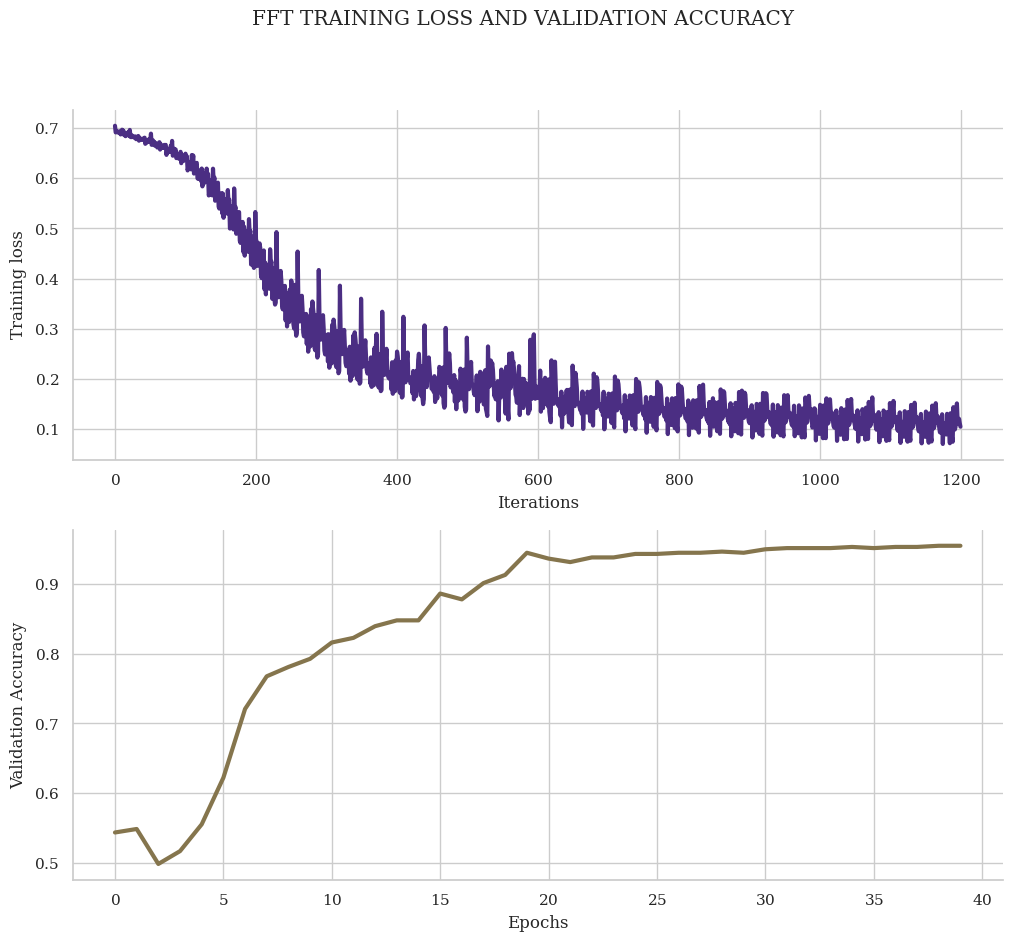

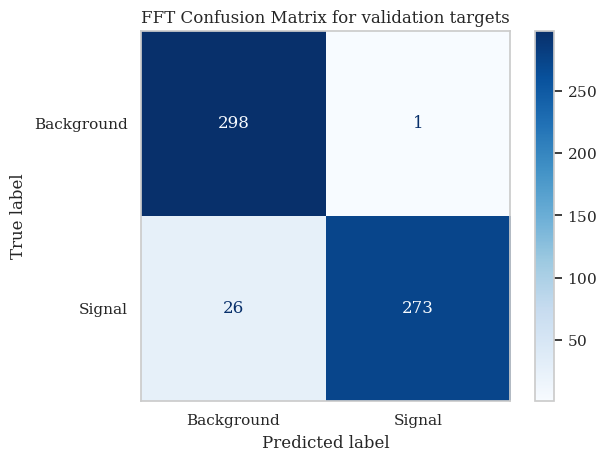

In [29]:
### -------------Plot the training loss and validation accuracy------------- ###

sns.set(style = 'whitegrid', font_scale = 1)
plt.figure(figsize = (12,10))
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.sans-serif"] = "Open Sans"

plt.subplot(2, 1, 1)
plt.plot(train_loss_list_spec, linewidth = 3, color="#4b2e83")
plt.ylabel("Training loss")
plt.xlabel("Iterations")


plt.subplot(2, 1, 2)
plt.plot(validation_accuracy_list_spec, linewidth = 3, color = "#85754d")
plt.ylabel("Validation Accuracy")
plt.xlabel("Epochs")
plt.suptitle("FFT TRAINING LOSS AND VALIDATION ACCURACY")
sns.despine()

plt.savefig("FFT_TrainLoss_ValAcc.png")


# torch.cuda.empty_cache()

### -------------Computing the Training accuracy------------- ###

with torch.no_grad():

    target_pred_test = model(train_inputs)
    train_correct = (torch.argmax(target_pred_test, dim=1) == train_targets).type(torch.FloatTensor)
    train_testing_acc = (train_correct.mean().numpy()*100)

### -------------Computing the testing accuracy------------- ###

with torch.no_grad():

    target_pred_test = model(testing_inputs)
    test_correct = (torch.argmax(target_pred_test, dim=1) == testing_targets).type(torch.FloatTensor)
    test_testing_acc = (test_correct.mean().numpy()*100) 

### -------------Computing the validation accuracy------------- ###

with torch.no_grad():

    target_pred_test = model(validation_inputs)
    val_correct = (torch.argmax(target_pred_test, dim=1) == validation_targets).type(torch.FloatTensor)
    val_testing_acc = (val_correct.mean().numpy()*100)


### -------------Confusion Matrix------------- ###

actual = validation_targets.cpu().numpy()
predicted = (torch.argmax(model(validation_inputs), dim=1)).cpu().numpy()

cm = confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(cm, 
                                            display_labels = ('Background', 'Signal'))
cm_display.plot(cmap=plt.cm.Blues, values_format = '')
plt.title('FFT Confusion Matrix for validation targets')
plt.grid(False)
plt.savefig("FFT_ConfMatrix.png")
plt.show()


Accuracy = metrics.accuracy_score(actual, predicted)*100
Precision = metrics.precision_score(actual, predicted)*100
Sensitivity_recall = metrics.recall_score(actual, predicted)*100
Specificity = metrics.recall_score(actual, predicted, pos_label=0)*100
F1_score = metrics.f1_score(actual, predicted)*100


acc = {'Training Accuracy': [train_testing_acc],
           'Testing Accuracy': [test_testing_acc],
           'Validation Accuracy': [val_testing_acc]}

results = pd.DataFrame(acc)
results.style.set_caption("FFT Accuracy Results")
results.to_csv('FFT Accuracy Results.csv', encoding='utf-8', index=False)


val = {'Accuracy': [Accuracy],
       'Precision': [Precision],
       'Sensitivity_recall': [Sensitivity_recall],
       'Specificity': [Specificity],
       'F1_score': [F1_score]}

val_results = pd.DataFrame(val)
val_results.style.set_caption("FFT Validation Results")
val_results.to_csv('FFT Validation Results.csv', encoding='utf-8', index=False)

-----

# Q Transform

## Preparing the data

In [4]:
# Might consider doing this to prevent crashing
torch.cuda.empty_cache() 

### -------------Load dataset------------- ###

# Define the file name
filename = 'classify_data.h5'

# Open the file
with h5py.File(filename, 'r') as file:
    # Load the datasets
    bbh_train = np.array(file['Training']['bbh'])
    bbh_val = np.array(file['Validation']['bbh'])
    glitch_train = np.array(file['Training']['glitch'])
    glitch_val = np.array(file['Validation']['glitch'])


### -------------Label our data as background or signal------------- ###

# Allows us to easily apply labels to our data to denote it as signal or background for classification.
anomaly_class = {
    'Glitch': 0,
    'Signal': 1
}

# ID our data as background or signal.
glitch_train_ids = np.full(glitch_train.shape[0], anomaly_class['Glitch'], dtype=int)
glitch_val_ids = np.full(glitch_val.shape[0], anomaly_class['Glitch'], dtype=int)

bbh_train_ids = np.full(bbh_train.shape[0], anomaly_class['Signal'], dtype=int)
bbh_val_ids = np.full(bbh_val.shape[0], anomaly_class['Signal'], dtype=int)



### -------------Merge dataset------------- ###

# Stick our background and signal data together for training and testing.
x_train = np.concatenate((glitch_train, bbh_train), axis=0).transpose((0,2,1))
y_train = np.concatenate((glitch_train_ids, bbh_train_ids), axis=0)

x_val_data = np.concatenate((glitch_val, bbh_val), axis=0).transpose((0,2,1))
y_val = np.concatenate((glitch_val_ids, bbh_val_ids), axis=0)



### -------------Shuffle dataset------------- ###

# Shuffle the training data using a randomly chosen permutation. This ensures we don't encounter artifacts from background 
# and signal data being clumped together.
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

#### Whitening and filtering

In [5]:
### -------------Split detector dataset------------- ###

# Each 2D dataset of gravitational wave data comes from one of two detectors: 1  and 2 
# Split the data from these two detectors since we can only pass 2D images into our CNN to train.
x_train_dec1_raw = x_train[:,:,0]
x_train_dec2_raw = x_train[:,:,1]

x_val_dec1_raw = x_val_data[:,:,0]
x_val_dec2_raw = x_val_data[:,:,1]




# Function to process a single item
def process_data(raw_data):


    # Bandpass filter for 50hz and 250hz
    bp = filter_design.bandpass(50, 250, 4096)

    ## First three harmonics of the 60 Hz AC mains power:
    notches = [filter_design.notch(line, 4096) for line in (60, 120, 180)]
    zpk = filter_design.concatenate_zpks(bp, *notches)



    hdata = TimeSeries(raw_data)
    hdata = hdata.whiten() 
    hdata = hdata.crop(*hdata.span.contract(1)) # The whitened timeseries data

    hfilt = hdata.filter(zpk, filtfilt=True)
    hfilt = hfilt.crop(*hfilt.span.contract(1)) # The filtered and whitened timeseries data

    return hdata, hfilt

In [6]:
# Process training data
x_train_dec1_data_arr = []
x_train_dec1_filt_arr = []
x_train_dec2_data_arr = []
x_train_dec2_filt_arr = []
x_val_dec1_data_arr = []
x_val_dec1_filt_arr = []
x_val_dec2_data_arr = []
x_val_dec2_filt_arr = []


for raw_data in tqdm(x_train_dec1_raw):
    hdata, hfilt = process_data(raw_data)
    x_train_dec1_data_arr.append(hdata)
    x_train_dec1_filt_arr.append(hfilt)

x_train_dec1_data_arr = np.asarray(x_train_dec1_data_arr)
x_train_dec1_filt_arr = np.asarray(x_train_dec1_filt_arr)


for raw_data in tqdm(x_train_dec2_raw):
    hdata, hfilt = process_data(raw_data)
    x_train_dec2_data_arr.append(hdata)
    x_train_dec2_filt_arr.append(hfilt)

x_train_dec2_data_arr = np.asarray(x_train_dec2_data_arr)
x_train_dec2_filt_arr = np.asarray(x_train_dec2_filt_arr)


for raw_data in tqdm(x_val_dec1_raw):
    hdata, hfilt = process_data(raw_data)
    x_val_dec1_data_arr.append(hdata)
    x_val_dec1_filt_arr.append(hfilt)

x_val_dec1_data_arr = np.asarray(x_val_dec1_data_arr)
x_val_dec1_filt_arr = np.asarray(x_val_dec1_filt_arr)


for raw_data in tqdm(x_val_dec2_raw):
    hdata, hfilt = process_data(raw_data)
    x_val_dec2_data_arr.append(hdata)
    x_val_dec2_filt_arr.append(hfilt)

x_val_dec2_data_arr = np.asarray(x_val_dec2_data_arr)
x_val_dec2_filt_arr = np.asarray(x_val_dec2_filt_arr)

100%|██████████| 598/598 [00:18<00:00, 32.12it/s]


---

##### NOTE: RESTART Q TRANSFORMS HERE WITHOUT HAVING TO WHITEN AND FILTER

In [7]:
#### START HERE IF YOU NEED TO RESTART WITHOUT HAVING TO WHITEN AND FILTER
y_train = np.concatenate((glitch_train_ids, bbh_train_ids), axis=0)
y_train = y_train[idx]

# # The whitened and filtered data
# x_train_dec1 = x_train_dec1_filt_arr
# x_train_dec2 = x_train_dec2_filt_arr
# x_val_dec1 = x_val_dec1_filt_arr
# x_val_dec2 = x_val_dec2_filt_arr

# Just the whitened data
x_train_dec1 = x_train_dec1_data_arr
x_train_dec2 = x_train_dec2_data_arr
x_val_dec1 = x_val_dec1_data_arr
x_val_dec2 = x_val_dec2_data_arr

---

## Converting to Q Transform

In [11]:
np.where(idx==13081)

(array([14120], dtype=int64),)

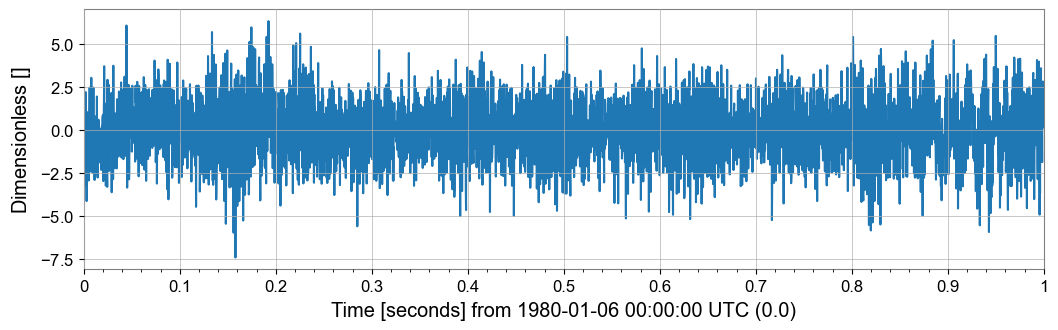

(64, 64)


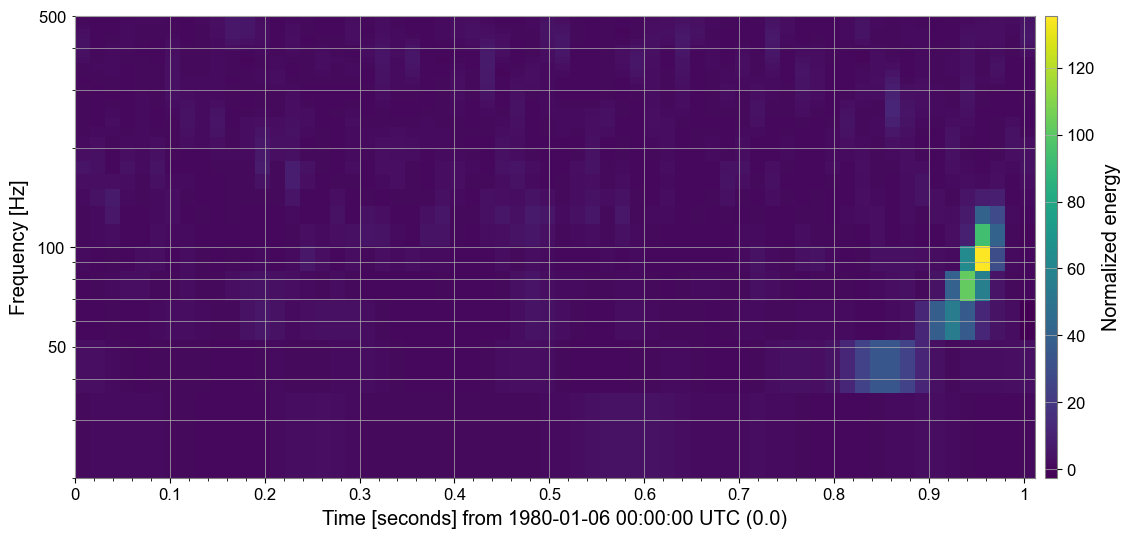

In [12]:
data = (x_train_dec1[14120,:])
series = (TimeSeries(data, sample_rate = 4096, t0=0))     #np.array --> constantQ.timeseries   

ts = series
ts_plot = ts.plot()
plt.xlim(0,1)
plt.show()

# # Q-Transformation
ts_qspectro = ts.q_transform(
    qrange=(3.3166, 108),
    frange=(20, 1054),
    whiten=False,
    tres = 0.0158,
    fres = 16.25)
print(ts_qspectro.shape)

q_plot = ts_qspectro.plot()
ax = q_plot.gca()
ax.set_xscale('seconds')
ax.set_yscale('log')
# ax.set_xlim(3.5, 4.5)
ax.set_ylim(20, 500)
ax.set_ylabel('Frequency [Hz]')
ax.grid(True, axis='y', which='both')
ax.colorbar(cmap='viridis', label='Normalized energy')
q_plot.show()


In [13]:
### -------------Convert to Q Spectrograms------------- ###

data_list = []
series_list = []
Q_list = []


datas = [x_train_dec1, x_train_dec2, x_val_dec1, x_val_dec2]

for d in range(len(datas)):
    data_list = []
    series_list = []
    Q_list = []


    for i in range(len(datas[d])):
        data = (datas[d][i,:])
        data_list.append(data)
        # print(datas[d].shape)
        series = (TimeSeries(data, sample_rate = 4096, t0=0))     #np.array --> constantQ.timeseries   
        series_list.append(series)

        series_spectro = series.q_transform(
        qrange=(3.3166, 108),
        frange=(20, 1054),
        whiten=False,
        tres = 0.0158,
        fres = 16.25)
        Q_list.append(series_spectro)




    if d == 0:
        data_arr_x_train_dec1 = np.stack(data_list, axis = 0)
        series_arr_x_train_dec1 = np.asarray(series_list)
        # Q_arr_x_train_dec1 = np.stack(Q_list, axis = 0)
        Q_arr_x_train_dec1 = np.asarray(Q_list)


    elif d == 1:
        data_arr_x_train_dec2 = np.stack(data_list, axis = 0)
        series_arr_x_train_dec2 = np.asarray(series_list)
        Q_arr_x_train_dec2 = np.asarray(Q_list)

    elif d == 2:
        data_arr_x_test_dec1 = np.stack(data_list, axis = 0)
        series_arr_x_test_dec1 = np.asarray(series_list)
        Q_arr_x_test_dec1 = np.asarray(Q_list)

    else:
        data_arr_x_test_dec2 = np.stack(data_list, axis = 0)
        series_arr_x_test_dec2 = np.asarray(series_list)
        Q_arr_x_test_dec2 = np.asarray(Q_list)




img_x_train_dec1 = Q_arr_x_train_dec1
img_x_train_dec2 = Q_arr_x_train_dec2
img_x_val_dec1 = Q_arr_x_test_dec1
img_x_val_dec2 = Q_arr_x_test_dec2




# Stack Detector 1 and Detector 2 image data together to unify our training and testing datasets before training.
x_train = np.stack((img_x_train_dec1, img_x_train_dec2), axis=1)
x_val = np.stack((img_x_val_dec1, img_x_val_dec2), axis=1)



### -------------Split into training and validation datasets------------- ###

# Take the first 17.65% of our training features and targets as validation set
x_test= x_train[:round((len(x_train)*0.1072))]
y_test = y_train[:round((len(y_train)*0.1072))]

# Take the remaining 82.35% of training features and targets as training set
x_train = x_train[round((len(x_train)*0.1072)):]
y_train = y_train[round((len(y_train)*0.1072)):]

# Check the shapes of the training/validation datasets. Turns out we get about a 80%, 13%, 2% split.
print("X Training Shape: ", x_train.shape)
print("Y Training Shape: ", y_train.shape)
print("X Validation Shape: ", x_val.shape)
print("Y Validation Shape: ", y_val.shape)
print("X Testing Shape: ", x_test.shape)
print("Y Testing Shape: ", y_test.shape)

X Training Shape:  (22854, 2, 64, 64)
Y Training Shape:  (22854,)
X Validation Shape:  (598, 2, 64, 64)
Y Validation Shape:  (598,)
X Testing Shape:  (2744, 2, 64, 64)
Y Testing Shape:  (2744,)


## CNN Model

In [14]:
### -------------Model Definition------------- ###

class CNNModel(torch.nn.Module):
    
    def __init__(self):
        
        super(CNNModel, self).__init__()

        # First convolution layer (2 channel -> 16 channels, preserve original dimension by adding padding = 2) 
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=2, out_channels=16, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=4, stride=2, padding=1)
            )
        
        # Second convolution layer (16 channel -> 32 channels, preserve dimension by adding padding = 2)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
            )

        # Fully connected layer that takes the flattened output of layer 2 (32, 7 ,7) -> (1568) and output 2 classes
        self.fc1 = torch.nn.Linear(in_features=32*8*8, out_features=128)
        self.fc2 = torch.nn.Linear(in_features=128, out_features=64)
        self.fc3 = torch.nn.Linear(in_features=64, out_features=2)
    
    def forward(self, x):

        # input image -> conv -> batchnorm -> relu -> maxpool
        out = self.layer1(x)
        # 1st maxpool output -> conv -> batchnorm -> relu -> maxpool
        out = self.layer2(out)
        # flatten the second maxpool output to be used as input into FCN layer
        out = out.view(out.size(0), -1)

        # Pass flattened output into FCN layers
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

## Hyperparameters

In [15]:
### -------------Hyperparameters------------- ###

# Initialize the CNN model
model = CNNModel()

# Define learning rate, epoch and batchsize for mini-batch gradient, and L2 regularization
learning_rate = 0.00005      #0.00005
epochs = 40                 # 75
batchsize = 768
L2_reg = 0.00005

# Define loss function and optimizer
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=L2_reg)

if torch.cuda.is_available():                                  # Checks if the GPU is available for processing
    model.cuda()                                               # Sends the model to the GPU for processing
model        



### -------------Identify tracked values------------- ###

train_loss_list_Q = []
validation_accuracy_list_Q = np.zeros((epochs,))


### -------------Training Model------------- ###

if torch.cuda.is_available():                   # If using CUDA version of PyTorch, dataset will be processed on GPU

    # Convert train/validation/test sets into torch tensors from numpy
    train_inputs = torch.from_numpy(x_train).float().cuda()
    train_targets = torch.from_numpy(y_train).long().cuda()

    validation_inputs = torch.from_numpy(x_val).float().cuda()
    validation_targets = torch.from_numpy(y_val).long().cuda()

    testing_inputs = torch.from_numpy(x_test).float().cuda()
    testing_targets = torch.from_numpy(y_test).long().cuda()

    # Split the training inputs/targets into mini-batches
    train_batches_features = torch.split(train_inputs, batchsize)
    train_batches_targets = torch.split(train_targets, batchsize)

else:                                           # If not using CUDA version of PyTorch, dataset will be processed on CPU

    # Convert train/validation/test sets into torch tensors from numpy
    train_inputs = torch.from_numpy(x_train).float()
    train_targets = torch.from_numpy(y_train).long()

    validation_inputs = torch.from_numpy(x_val).float()
    validation_targets = torch.from_numpy(y_val).long()

    testing_inputs = torch.from_numpy(x_test).float()
    testing_targets = torch.from_numpy(y_test).long()

    # Split the training inputs/targets into mini-batches
    train_batches_features = torch.split(train_inputs, batchsize)
    train_batches_targets = torch.split(train_targets, batchsize)

# length of train_batches_features = total number of mini-batches in the training set
batch_split_num = len(train_batches_features)

## Training loop

In [16]:
### -------------Training Loop------------- ###
## NOTE: CHANGE DESC TO INCLUDE CHANGING EPOCHS

for epoch in trange(epochs, desc='Training Model on 40 Epochs'):
    start_time = timer() # start timer
    # Each mini-batch number i, grab i-th training feature and target mini-batch and perform fwd/bwd pass on the network
    
    for i in trange(batch_split_num, desc=f'Epoch {epoch}'):
    
        optimizer.zero_grad()    
        train_batch_outputs = model(train_batches_features[i])  
        loss = loss_func(train_batch_outputs, train_batches_targets[i])
        train_loss_list_Q.append(loss.item())       
        loss.backward()
        optimizer.step()

    end_time = timer() # End timer

    ### -------------Compute Validation Accuracy------------- ###

    with torch.no_grad():

        validation_outputs = model(validation_inputs)
        val_correct = (torch.argmax(validation_outputs, dim=1) == validation_targets).type(torch.FloatTensor)
        validation_accuracy_list_Q[epoch] = val_correct.mean()  
                      
        print("Epoch: "+ str(epoch),
              "Epoch time: " + str(np.round(end_time - start_time, 2)) + "s",
              "Validation Accuracy: " + str(np.round(val_correct.mean().numpy() * 100, 2)) + '%',
              "Training loss: " + str(np.round(loss.item(), 2)), flush=True)

Epoch 0: 100%|██████████| 30/30 [00:07<00:00,  3.96it/s]0<?, ?it/s]

Epoch: 0 Epoch time: 7.58s Validation Accuracy: 51.84% Training loss: 0.68



Epoch 1: 100%|██████████| 30/30 [00:00<00:00, 36.31it/s]7<04:56,  7.60s/it]

Epoch: 1 Epoch time: 0.83s Validation Accuracy: 58.03% Training loss: 0.68



Epoch 2: 100%|██████████| 30/30 [00:00<00:00, 35.03it/s]8<02:17,  3.63s/it]

Epoch: 2 Epoch time: 0.86s Validation Accuracy: 59.36% Training loss: 0.67



Epoch 3: 100%|██████████| 30/30 [00:00<00:00, 37.37it/s]9<01:27,  2.37s/it]

Epoch: 3 Epoch time: 0.81s Validation Accuracy: 64.05% Training loss: 0.66



Epoch 4: 100%|██████████| 30/30 [00:00<00:00, 37.37it/s]0<01:03,  1.76s/it]

Epoch: 4 Epoch time: 0.81s Validation Accuracy: 69.06% Training loss: 0.65



Epoch 5: 100%|██████████| 30/30 [00:00<00:00, 38.95it/s]0<00:49,  1.42s/it]

Epoch: 5 Epoch time: 0.77s Validation Accuracy: 72.41% Training loss: 0.64



Epoch 6: 100%|██████████| 30/30 [00:00<00:00, 38.03it/s]1<00:41,  1.21s/it]

Epoch: 6 Epoch time: 0.79s Validation Accuracy: 74.25% Training loss: 0.62



Epoch 7: 100%|██████████| 30/30 [00:00<00:00, 38.96it/s]2<00:35,  1.08s/it]

Epoch: 7 Epoch time: 0.78s Validation Accuracy: 76.25% Training loss: 0.61



Epoch 8: 100%|██████████| 30/30 [00:00<00:00, 38.75it/s]3<00:31,  1.01it/s]

Epoch: 8 Epoch time: 0.78s Validation Accuracy: 76.59% Training loss: 0.6



Epoch 9: 100%|██████████| 30/30 [00:00<00:00, 38.77it/s]4<00:29,  1.07it/s]

Epoch: 9 Epoch time: 0.78s Validation Accuracy: 77.09% Training loss: 0.59



Epoch 10: 100%|██████████| 30/30 [00:00<00:00, 39.55it/s]5<00:26,  1.12it/s]

Epoch: 10 Epoch time: 0.76s Validation Accuracy: 77.59% Training loss: 0.58



Epoch 11: 100%|██████████| 30/30 [00:00<00:00, 38.97it/s]5<00:24,  1.16it/s]

Epoch: 11 Epoch time: 0.77s Validation Accuracy: 77.26% Training loss: 0.56



Epoch 12: 100%|██████████| 30/30 [00:00<00:00, 38.82it/s]6<00:23,  1.19it/s]

Epoch: 12 Epoch time: 0.78s Validation Accuracy: 78.09% Training loss: 0.55



Epoch 13: 100%|██████████| 30/30 [00:00<00:00, 38.20it/s]7<00:22,  1.21it/s]

Epoch: 13 Epoch time: 0.79s Validation Accuracy: 77.93% Training loss: 0.54



Epoch 14: 100%|██████████| 30/30 [00:00<00:00, 39.41it/s]8<00:21,  1.22it/s]

Epoch: 14 Epoch time: 0.77s Validation Accuracy: 79.1% Training loss: 0.54



Epoch 15: 100%|██████████| 30/30 [00:00<00:00, 39.50it/s]8<00:20,  1.24it/s]

Epoch: 15 Epoch time: 0.76s Validation Accuracy: 80.6% Training loss: 0.53



Epoch 16: 100%|██████████| 30/30 [00:00<00:00, 38.63it/s]9<00:19,  1.25it/s]

Epoch: 16 Epoch time: 0.78s Validation Accuracy: 80.6% Training loss: 0.5



Epoch 17: 100%|██████████| 30/30 [00:00<00:00, 37.98it/s]0<00:18,  1.25it/s]

Epoch: 17 Epoch time: 0.79s Validation Accuracy: 80.94% Training loss: 0.5



Epoch 18: 100%|██████████| 30/30 [00:00<00:00, 39.22it/s]1<00:17,  1.24it/s]

Epoch: 18 Epoch time: 0.77s Validation Accuracy: 81.77% Training loss: 0.5



Epoch 19: 100%|██████████| 30/30 [00:00<00:00, 38.76it/s]2<00:16,  1.25it/s]

Epoch: 19 Epoch time: 0.78s Validation Accuracy: 81.44% Training loss: 0.5



Epoch 20: 100%|██████████| 30/30 [00:00<00:00, 38.56it/s]2<00:15,  1.25it/s]

Epoch: 20 Epoch time: 0.78s Validation Accuracy: 82.11% Training loss: 0.5



Epoch 21: 100%|██████████| 30/30 [00:00<00:00, 38.60it/s]3<00:15,  1.25it/s]

Epoch: 21 Epoch time: 0.78s Validation Accuracy: 81.94% Training loss: 0.5



Epoch 22: 100%|██████████| 30/30 [00:00<00:00, 39.43it/s]4<00:14,  1.25it/s]

Epoch: 22 Epoch time: 0.77s Validation Accuracy: 81.61% Training loss: 0.5



Epoch 23: 100%|██████████| 30/30 [00:00<00:00, 38.92it/s]5<00:13,  1.26it/s]

Epoch: 23 Epoch time: 0.78s Validation Accuracy: 81.77% Training loss: 0.5



Epoch 24: 100%|██████████| 30/30 [00:00<00:00, 37.99it/s]6<00:12,  1.26it/s]

Epoch: 24 Epoch time: 0.79s Validation Accuracy: 81.94% Training loss: 0.5



Epoch 25: 100%|██████████| 30/30 [00:00<00:00, 38.43it/s]6<00:12,  1.25it/s]

Epoch: 25 Epoch time: 0.79s Validation Accuracy: 82.44% Training loss: 0.5



Epoch 26: 100%|██████████| 30/30 [00:00<00:00, 38.57it/s]7<00:11,  1.24it/s]

Epoch: 26 Epoch time: 0.78s Validation Accuracy: 81.94% Training loss: 0.49



Epoch 27: 100%|██████████| 30/30 [00:00<00:00, 38.62it/s]8<00:10,  1.25it/s]

Epoch: 27 Epoch time: 0.78s Validation Accuracy: 82.27% Training loss: 0.49



Epoch 28: 100%|██████████| 30/30 [00:00<00:00, 37.73it/s]9<00:09,  1.25it/s]

Epoch: 28 Epoch time: 0.81s Validation Accuracy: 82.27% Training loss: 0.48



Epoch 29: 100%|██████████| 30/30 [00:00<00:00, 38.58it/s]0<00:08,  1.23it/s]

Epoch: 29 Epoch time: 0.78s Validation Accuracy: 82.61% Training loss: 0.48



Epoch 30: 100%|██████████| 30/30 [00:00<00:00, 38.50it/s]0<00:08,  1.24it/s]

Epoch: 30 Epoch time: 0.78s Validation Accuracy: 82.11% Training loss: 0.48



Epoch 31: 100%|██████████| 30/30 [00:00<00:00, 39.32it/s]1<00:07,  1.24it/s]

Epoch: 31 Epoch time: 0.77s Validation Accuracy: 82.11% Training loss: 0.47



Epoch 32: 100%|██████████| 30/30 [00:00<00:00, 38.43it/s]2<00:06,  1.25it/s]

Epoch: 32 Epoch time: 0.79s Validation Accuracy: 81.44% Training loss: 0.47



Epoch 33: 100%|██████████| 30/30 [00:00<00:00, 38.34it/s]3<00:05,  1.25it/s]

Epoch: 33 Epoch time: 0.79s Validation Accuracy: 81.44% Training loss: 0.47



Epoch 34: 100%|██████████| 30/30 [00:00<00:00, 39.22it/s]4<00:04,  1.25it/s]

Epoch: 34 Epoch time: 0.77s Validation Accuracy: 81.44% Training loss: 0.46



Epoch 35: 100%|██████████| 30/30 [00:00<00:00, 39.26it/s]4<00:03,  1.26it/s]

Epoch: 35 Epoch time: 0.77s Validation Accuracy: 81.27% Training loss: 0.46



Epoch 36: 100%|██████████| 30/30 [00:00<00:00, 39.04it/s]5<00:03,  1.26it/s]

Epoch: 36 Epoch time: 0.77s Validation Accuracy: 81.27% Training loss: 0.45



Epoch 37: 100%|██████████| 30/30 [00:00<00:00, 38.64it/s]6<00:02,  1.26it/s]

Epoch: 37 Epoch time: 0.78s Validation Accuracy: 81.27% Training loss: 0.45



Epoch 38: 100%|██████████| 30/30 [00:00<00:00, 38.57it/s]7<00:01,  1.26it/s]

Epoch: 38 Epoch time: 0.79s Validation Accuracy: 81.61% Training loss: 0.44



Epoch 39: 100%|██████████| 30/30 [00:00<00:00, 37.91it/s]8<00:00,  1.25it/s]

Epoch: 39 Epoch time: 0.79s Validation Accuracy: 81.44% Training loss: 0.44



Training Model on 40 Epochs: 100%|██████████| 40/40 [00:38<00:00,  1.03it/s]


## Visualize & Evaluate Model

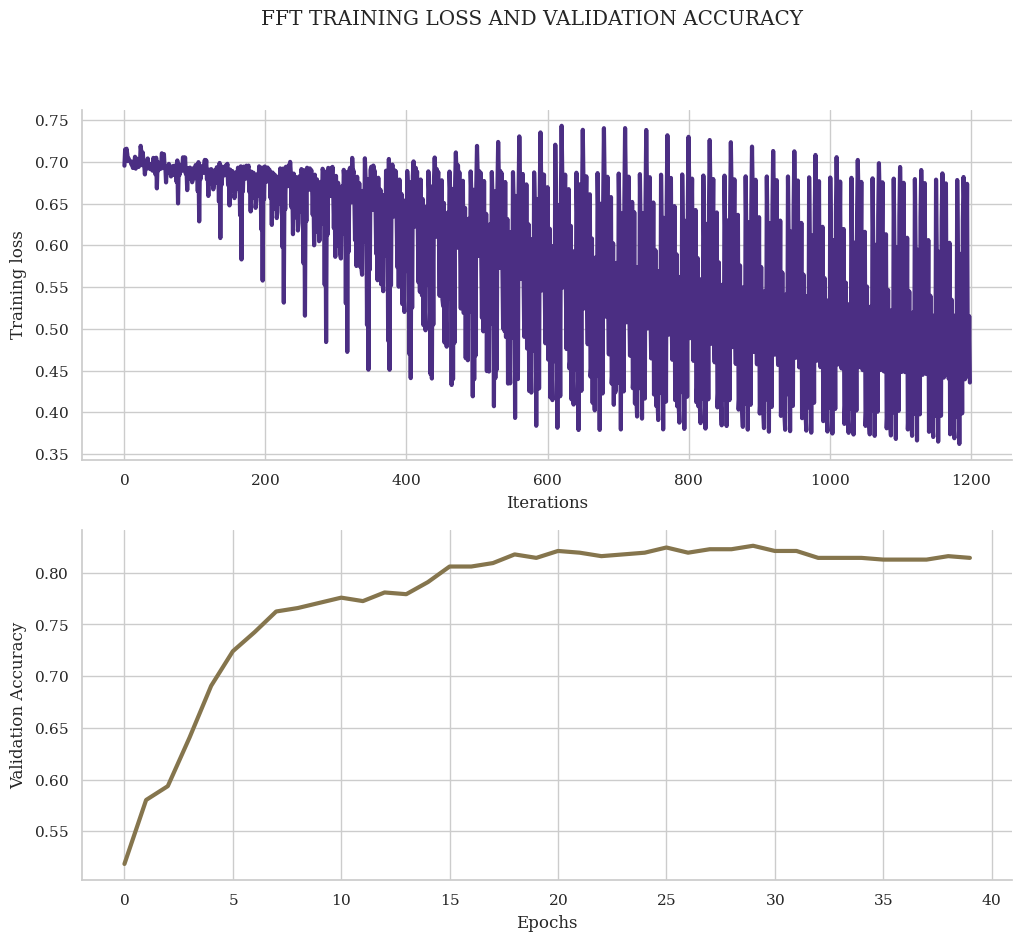

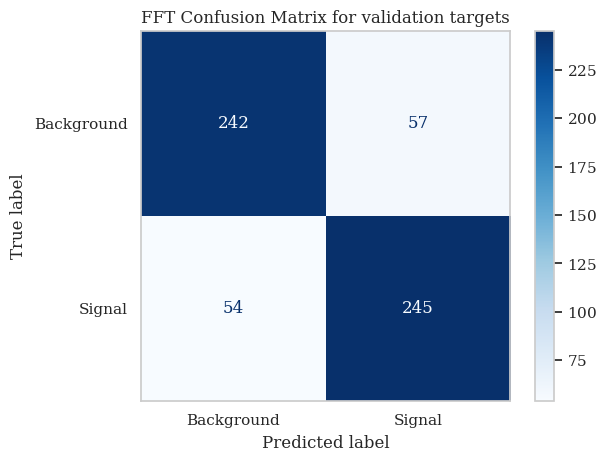

In [17]:
### -------------Plot the training loss and validation accuracy------------- ###

sns.set(style = 'whitegrid', font_scale = 1)
plt.figure(figsize = (12,10))
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.sans-serif"] = "Open Sans"

plt.subplot(2, 1, 1)
plt.plot(train_loss_list_Q, linewidth = 3, color="#4b2e83")
plt.ylabel("Training loss")
plt.xlabel("Iterations")


plt.subplot(2, 1, 2)
plt.plot(validation_accuracy_list_Q, linewidth = 3, color = "#85754d")
plt.ylabel("Validation Accuracy")
plt.xlabel("Epochs")
plt.suptitle("FFT TRAINING LOSS AND VALIDATION ACCURACY")
sns.despine()

plt.savefig("FFT_TrainLoss_ValAcc.png")


# torch.cuda.empty_cache()

### -------------Computing the Training accuracy------------- ###

with torch.no_grad():

    target_pred_test = model(train_inputs)
    train_correct = (torch.argmax(target_pred_test, dim=1) == train_targets).type(torch.FloatTensor)
    train_testing_acc = (train_correct.mean().numpy()*100)

### -------------Computing the testing accuracy------------- ###

with torch.no_grad():

    target_pred_test = model(testing_inputs)
    test_correct = (torch.argmax(target_pred_test, dim=1) == testing_targets).type(torch.FloatTensor)
    test_testing_acc = (test_correct.mean().numpy()*100) 

### -------------Computing the validation accuracy------------- ###

with torch.no_grad():

    target_pred_test = model(validation_inputs)
    val_correct = (torch.argmax(target_pred_test, dim=1) == validation_targets).type(torch.FloatTensor)
    val_testing_acc = (val_correct.mean().numpy()*100)


### -------------Confusion Matrix------------- ###

actual = validation_targets.cpu().numpy()
predicted = (torch.argmax(model(validation_inputs), dim=1)).cpu().numpy()

cm = confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(cm, 
                                            display_labels = ('Background', 'Signal'))
cm_display.plot(cmap=plt.cm.Blues, values_format = '')
plt.title('FFT Confusion Matrix for validation targets')
plt.grid(False)
plt.savefig("FFT_ConfMatrix.png")
plt.show()


Accuracy = metrics.accuracy_score(actual, predicted)*100
Precision = metrics.precision_score(actual, predicted)*100
Sensitivity_recall = metrics.recall_score(actual, predicted)*100
Specificity = metrics.recall_score(actual, predicted, pos_label=0)*100
F1_score = metrics.f1_score(actual, predicted)*100


acc = {'Training Accuracy': [train_testing_acc],
           'Testing Accuracy': [test_testing_acc],
           'Validation Accuracy': [val_testing_acc]}

results = pd.DataFrame(acc)
results.style.set_caption("FFT Accuracy Results")
results.to_csv('FFT Accuracy Results.csv', encoding='utf-8', index=False)


val = {'Accuracy': [Accuracy],
       'Precision': [Precision],
       'Sensitivity_recall': [Sensitivity_recall],
       'Specificity': [Specificity],
       'F1_score': [F1_score]}

val_results = pd.DataFrame(val)
val_results.style.set_caption("FFT Validation Results")
val_results.to_csv('FFT Validation Results.csv', encoding='utf-8', index=False)